In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
# import matplotlib.cbook as cbook
# import matplotlib.dates as mdates


# Data

In [2]:
import math
import pandas as pd
import os.path
from datetime import timedelta, datetime
from dateutil import parser
from binance.client import Client as Client_binance


class BinanceClient(object):

    def __init__(self,
                 config):
        self.binance_api_key = config['binance_api_key']
        self.binance_api_secret = config['binance_api_secret']

        self.client = Client_binance(api_key=self.binance_api_key, api_secret=self.binance_api_secret)

    ### FUNCTIONS
    def minutes_of_new_data(self, symbol, initial_date,
                            kline_size, data, source):
        if len(data) > 0:
            old = parser.parse(data["timestamp"].iloc[-1])
        elif source == "binance":
            old = datetime.strptime(initial_date, '%d %b %Y')
        if source == "binance":
            new = pd.to_datetime(self.client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
        return old, new
    
    def get_all_binance(self, symbol, initial_date, freq, save=False):
        binsizes = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "6h": 360, "12h": 720, "1d": 1440}
        filename = '/home/agustin/Git-Repos/algo-trading-crypto/il-hedger/il_hedger/files/%s-%s-data.csv' % (symbol, freq)
        if os.path.isfile(filename):
            data_df = pd.read_csv(filename)
        else:
            data_df = pd.DataFrame()
        oldest_point, newest_point = self.minutes_of_new_data(symbol, initial_date,
                                                              freq, data_df, source="binance")
        delta_min = (newest_point - oldest_point).total_seconds() / 60
        available_data = math.ceil(delta_min / binsizes[freq])
        if oldest_point == datetime.strptime(initial_date, '%d %b %Y'):
            print('Downloading all available %s data for %s. Be patient..!' % (freq, symbol))
        else:
            print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.'
                  % (delta_min, symbol, available_data, freq))
        klines = self.client.get_historical_klines(symbol, freq,
                                                   oldest_point.strftime("%d %b %Y %H:%M:%S"),
                                                   newest_point.strftime("%d %b %Y %H:%M:%S"))
        data = pd.DataFrame(klines,
                            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                     'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        if len(data_df) > 0:
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
        else:
            data_df = data
        data_df.set_index('timestamp', inplace=True)
        if save:
            data_df.to_csv(filename)
        print('All caught up..!')
        return data_df

import json

with open('/home/agustin/Git-Repos/HedgingScripts/files/StgyApp_config.json') as json_file:
    config = json.load(json_file)
_binance_client_ = BinanceClient(config['binance_client'])


# Track historical data
symbol_eth = 'ETHBUSD'
symbol_btc = 'BTCBUSD'
freq = '1d'
initial_date = "1 Jan 2021"
_binance_client_ = BinanceClient(config['binance_client'])
eth_historical = _binance_client_.get_all_binance(symbol=symbol_eth, freq=freq,
                              initial_date=initial_date, save=False)
btc_historical = _binance_client_.get_all_binance(symbol=symbol_btc, freq=freq,
                              initial_date=initial_date, save=False)
eth_prices = eth_historical['close']
for i in range(len(eth_prices)):
    eth_prices[i] = float(eth_prices[i])
btc_prices = btc_historical['close']
for i in range(len(btc_prices)):
    btc_prices[i] = float(btc_prices[i])

All caught up..!
All caught up..!


<ipython-input-2-6a9e21f37cc2>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices[i] = float(eth_prices[i])
<ipython-input-2-6a9e21f37cc2>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_prices[i] = float(btc_prices[i])


In [3]:
eth_prices.to_csv('eth_prices.csv')
btc_prices.to_csv('btc_prices.csv')

In [3]:
# data
# data = btc_historical
data_eth_2021 = pd.DataFrame(eth_prices).loc["2021-01-01":"2022-01-01"]
data_btc_2021 = pd.DataFrame(btc_prices).loc["2021-01-01":"2022-01-01"]

data_eth_2022 = pd.DataFrame(eth_prices).loc["2022-01-01":"2023-01-01"]
data_btc_2022 = pd.DataFrame(btc_prices).loc["2022-01-01":"2023-01-01"]

# Note that last dataset in each set of periods has a length of less than one expect for that period, 
# so is better to take all the periods except the last one. ie [:-1]

data_7days_eth_2021 = [data_eth_2021[i:i+7] for i in range(len(data_eth_2021)) if i % 7 == 0][:-1]
data_7days_btc_2021 = [data_btc_2021[i:i+7] for i in range(len(data_btc_2021)) if i % 7 == 0][:-1]

data_7days_eth_2022 = [data_eth_2022[i:i+7] for i in range(len(data_eth_2022)) if i % 7 == 0][:-1]
data_7days_btc_2022 = [data_btc_2022[i:i+7] for i in range(len(data_btc_2022)) if i % 7 == 0][:-1]

data_15days_eth_2021 = [data_eth_2021[i:i+15] for i in range(len(data_eth_2021)) if i % 15 == 0][:-1]
data_15days_btc_2021 = [data_btc_2021[i:i+15] for i in range(len(data_btc_2021)) if i % 15 == 0][:-1]

data_15days_eth_2022 = [data_eth_2022[i:i+15] for i in range(len(data_eth_2022)) if i % 15 == 0][:-1]
data_15days_btc_2022 = [data_btc_2022[i:i+15] for i in range(len(data_btc_2022)) if i % 15 == 0][:-1]

data_30days_eth_2021 = [data_eth_2021[i:i+30] for i in range(len(data_eth_2021)) if i % 30 == 0][:-1]
data_30days_btc_2021 = [data_btc_2021[i:i+30] for i in range(len(data_btc_2021)) if i % 30 == 0][:-1]

data_30days_eth_2022 = [data_eth_2022[i:i+30] for i in range(len(data_eth_2022)) if i % 30 == 0][:-1]
data_30days_btc_2022 = [data_btc_2022[i:i+30] for i in range(len(data_btc_2022)) if i % 30 == 0][:-1]

Note that last dataset in each set of periods has a length of less than one expect for that period, so is better to take all the periods except the last one.

In [107]:
len(data_7days_eth_2022[-1]),len(data_15days_eth_2022[-1]),len(data_30days_eth_2022[-1])

(52, 24, 12)

Let's read parameters for strategies from a csv.

In [4]:
# Import pandas
import pandas as pd

# Load the xlsx file
parameters_eth_7_eur = pd.read_excel('Parameters/Orbit-Cruize_eth_eur.xlsx', sheet_name='7')
parameters_eth_15_eur = pd.read_excel('Parameters/Orbit-Cruize_eth_eur.xlsx', sheet_name='15')
parameters_eth_30_eur = pd.read_excel('Parameters/Orbit-Cruize_eth_eur.xlsx', sheet_name='30')

parameters_eth_7_amer = pd.read_excel('Parameters/Orbit-Cruize_eth_amer.xlsx', sheet_name='7')
parameters_eth_15_amer = pd.read_excel('Parameters/Orbit-Cruize_eth_amer.xlsx', sheet_name='15')
parameters_eth_30_amer = pd.read_excel('Parameters/Orbit-Cruize_eth_amer.xlsx', sheet_name='30')

parameters_btc_7_eur = pd.read_excel('Parameters/Orbit-Cruize_btc_eur.xlsx', sheet_name='7')
parameters_btc_15_eur = pd.read_excel('Parameters/Orbit-Cruize_btc_eur.xlsx', sheet_name='15')
parameters_btc_30_eur = pd.read_excel('Parameters/Orbit-Cruize_btc_eur.xlsx', sheet_name='30')

parameters_btc_7_amer = pd.read_excel('Parameters/Orbit-Cruize_btc_amer.xlsx', sheet_name='7')
parameters_btc_15_amer = pd.read_excel('Parameters/Orbit-Cruize_btc_amer.xlsx', sheet_name='15')
parameters_btc_30_amer = pd.read_excel('Parameters/Orbit-Cruize_btc_amer.xlsx', sheet_name='30')


In [5]:
# parameters_eth_7_amer = pd.read_excel('cruize30jan.xlsx')
# parameters_btc_7_amer = pd.read_excel('btc_cruise30jan.xlsx')

In [6]:
# eth_7_ascent_parameters_amer = pd.DataFrame(parameters_eth_7_amer.iloc[3:8]) 
# eth_7_ascent_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

# eth_7_twin_win_parameters_amer = parameters_eth_7_amer.iloc[8:13]
# eth_7_twin_win_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

# eth_7_highland_parameters_amer = parameters_eth_7_amer.iloc[13:19]
# eth_7_highland_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

# btc_7_ascent_parameters_amer = pd.DataFrame(parameters_btc_7_amer.iloc[3:8]) 
# btc_7_ascent_parameters_amer.columns = ['btc', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

# btc_7_twin_win_parameters_amer = parameters_btc_7_amer.iloc[8:13]
# btc_7_twin_win_parameters_amer.columns = ['btc', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

# btc_7_highland_parameters_amer = parameters_btc_7_amer.iloc[13:19]
# btc_7_highland_parameters_amer.columns = ['btc', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

In [5]:
eth_7_ascent_parameters_eur = pd.DataFrame(parameters_eth_7_eur.iloc[3:8]) 
eth_7_ascent_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_7_twin_win_parameters_eur = parameters_eth_7_eur.iloc[8:13]
eth_7_twin_win_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_7_highland_parameters_eur = parameters_eth_7_eur.iloc[13:17]
eth_7_highland_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_7_corridor_parameters = parameters_eth_7_eur.iloc[17:21]
eth_7_corridor_parameters.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_7_ascent_parameters_amer = pd.DataFrame(parameters_eth_7_amer.iloc[3:8]) 
eth_7_ascent_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_7_twin_win_parameters_amer = parameters_eth_7_amer.iloc[8:13]
eth_7_twin_win_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_7_highland_parameters_amer = parameters_eth_7_amer.iloc[13:19]
eth_7_highland_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']


btc_7_ascent_parameters_eur = pd.DataFrame(parameters_btc_7_eur.iloc[3:8]) 
btc_7_ascent_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_7_twin_win_parameters_eur = parameters_btc_7_eur.iloc[8:13]
btc_7_twin_win_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_7_highland_parameters_eur = parameters_btc_7_eur.iloc[13:17]
btc_7_highland_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_7_corridor_parameters = parameters_btc_7_eur.iloc[17:21]
btc_7_corridor_parameters.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_7_ascent_parameters_amer = pd.DataFrame(parameters_btc_7_amer.iloc[3:8]) 
btc_7_ascent_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_7_twin_win_parameters_amer = parameters_btc_7_amer.iloc[8:13]
btc_7_twin_win_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_7_highland_parameters_amer = parameters_btc_7_amer.iloc[13:19]
btc_7_highland_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

In [24]:
eth_7_twin_win_parameters_eur.loc[11]['Base Coupon'] = 0.04

,eth,Lower Barrier,Upper Barrier,Base Coupon,Participation Rate,Bonus Coupon,Max APR
8,Twin Win,0.98,1.02,0.005,13,0.26,0.265
9,NaN,0.96,1.04,0.005,3.75,0.15,0.155
10,NaN,0.94,1.06,0.005,1.9,0.114,0.119
11,NaN,0.92,1.08,0.04,1.35,0.108,0.113
12,NaN,0.9,1.1,0.005,0.85,0.085,0.09


In [11]:
btc_7_highland_parameters_amer

,eth,Lower Barrier,Upper Barrier,Base Coupon,Participation Rate,Bonus Coupon,Max APR
13,NaN,0.88,1.12,0.02,1,0.0219,0.0419
14,NaN,0.86,1.14,0.02,1,0.0198,0.0398
15,NaN,0.84,1.16,0.02,1,0.0181,0.0381


In [6]:
eth_15_ascent_parameters_eur = pd.DataFrame(parameters_eth_15_eur.iloc[3:8]) 
eth_15_ascent_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_15_twin_win_parameters_eur = parameters_eth_15_eur.iloc[8:13]
eth_15_twin_win_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_15_highland_parameters_eur = parameters_eth_15_eur.iloc[13:17]
eth_15_highland_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_15_corridor_parameters = parameters_eth_15_eur.iloc[17:21]
eth_15_corridor_parameters.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_15_ascent_parameters_amer = pd.DataFrame(parameters_eth_15_amer.iloc[3:8]) 
eth_15_ascent_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_15_twin_win_parameters_amer = parameters_eth_15_amer.iloc[8:13]
eth_15_twin_win_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_15_highland_parameters_amer = parameters_eth_15_amer.iloc[13:19]
eth_15_highland_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_15_ascent_parameters_eur = pd.DataFrame(parameters_btc_15_eur.iloc[3:8]) 
btc_15_ascent_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_15_twin_win_parameters_eur = parameters_btc_15_eur.iloc[8:13]
btc_15_twin_win_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_15_highland_parameters_eur = parameters_btc_15_eur.iloc[13:17]
btc_15_highland_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_15_corridor_parameters = parameters_btc_15_eur.iloc[17:21]
btc_15_corridor_parameters.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_15_ascent_parameters_amer = pd.DataFrame(parameters_btc_15_amer.iloc[3:8]) 
btc_15_ascent_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_15_twin_win_parameters_amer = parameters_btc_15_amer.iloc[8:13]
btc_15_twin_win_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_15_highland_parameters_amer = parameters_btc_15_amer.iloc[13:19]
btc_15_highland_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']


In [10]:
eth_30_ascent_parameters_eur = pd.DataFrame(parameters_eth_30_eur.iloc[3:8]) 
eth_30_ascent_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_30_twin_win_parameters_eur = parameters_eth_30_eur.iloc[8:13]
eth_30_twin_win_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_30_highland_parameters_eur = parameters_eth_30_eur.iloc[13:17]
eth_30_highland_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_30_corridor_parameters = parameters_eth_30_eur.iloc[17:21]
eth_30_corridor_parameters.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_30_ascent_parameters_amer = pd.DataFrame(parameters_eth_30_amer.iloc[3:8]) 
eth_30_ascent_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_30_twin_win_parameters_amer = parameters_eth_30_amer.iloc[8:13]
eth_30_twin_win_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

eth_30_highland_parameters_amer = parameters_eth_30_amer.iloc[13:19]
eth_30_highland_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_30_ascent_parameters_eur = pd.DataFrame(parameters_btc_30_eur.iloc[3:8]) 
btc_30_ascent_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_30_twin_win_parameters_eur = parameters_btc_30_eur.iloc[8:13]
btc_30_twin_win_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_30_highland_parameters_eur = parameters_btc_30_eur.iloc[13:17]
btc_30_highland_parameters_eur.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_30_corridor_parameters = parameters_btc_30_eur.iloc[17:21]
btc_30_corridor_parameters.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_30_ascent_parameters_amer = pd.DataFrame(parameters_btc_30_amer.iloc[3:8]) 
btc_30_ascent_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_30_twin_win_parameters_amer = parameters_btc_30_amer.iloc[8:13]
btc_30_twin_win_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

btc_30_highland_parameters_amer = parameters_btc_30_amer.iloc[13:19]
btc_30_highland_parameters_amer.columns = ['eth', 'Lower Barrier', 'Upper Barrier', 'Base Coupon','Participation Rate', 'Bonus Coupon','Max APR']

In [7]:
def convert_to_pcg(data_set):
    for col in list(data_set.columns):
        for i in list(data_set.index):
            if (i == 'APY') | (i == 'APR') | (i == 'MAX_APY') | (i == 'MAX_APR'):
                data_set[col][i] = str(round((data_set[col][i]-1)*100,3)) + '%'
            else:
                data_set[col][i] = str(round(data_set[col][i]*100,3)) + '%'
    return data_set

In [12]:
def write_excel(data, directory, sheet_name):# ascent_eth.to_csv('Ascent.csv', index=False)
    # ascent_btc.to_csv('Ascent.csv', index=False, mode="a")
    # Create a Pandas Excel writer using XlsxWriter as the engine.
#     writer = pd.ExcelWriter('Results/Ascent_monthly_european_2022.xlsx', engine='xlsxwriter')
    writer = pd.ExcelWriter(directory, engine='xlsxwriter')
    # writer = pd.ExcelWriter('Ascent_monthly_american_2022.xlsx', engine='xlsxwriter')

    # Write each dataframe to a different worksheet.
    data.to_excel(writer, sheet_name=sheet_name)
    # df3.to_excel(writer, sheet_name='Sheet3')

    # Close the Pandas Excel writer and output the Excel file.
    writer.close()
    

## Ascent

In [9]:
def Ascent(P, upper_barrier, strike_price):
    bad_condition = P > upper_barrier
    if bad_condition:
        return 0
    else:
        return max(P/strike_price-1, 0)
    
def Ascent(week, upper_barrier, strike_price, P_last, style):
    if style == 'american':
        for P in week['close']:
            if P > upper_barrier:
                return 0
    if P_last > upper_barrier:
        return 0
    else:
        return max(P_last/strike_price-1, 0)

In [10]:
def Ascent_backtest(data_periods, parameters_period, style):
#     data_period = data_biweek_eth #data_months_eth
#     parameters_period = eth_15_ascent_parameters #eth_30_ascent_parameters
    index = ['period_'+str(i) for i in range(len(data_periods))]
    other_parameters = ['Avg', 'Max', 'APY', 'APR', 'MAX_APY', 'MAX_APR']
    index += other_parameters
    periods_in_one_year = len(data_periods)#-1 # We remove last period in data_periods bc it has less than len(period) prices
    # index_parameters = list(eth_30_ascent_parameters.index)
    columns = [str([strike, barrier]) for strike,barrier in 
               zip(parameters_period['Lower Barrier'],#.loc[index_parameters[-1:]],
                   parameters_period['Upper Barrier'])]+[str([strike, barrier])+'_APR' for strike,barrier in 
               zip(parameters_period['Lower Barrier'],
                   parameters_period['Upper Barrier'])]+[str([strike, barrier])+'_APY' for strike,barrier in 
               zip(parameters_period['Lower Barrier'],
                   parameters_period['Upper Barrier'])]
    ascent_period_results = pd.DataFrame(index=index, 
                          columns = columns)
    for strike, barrier, coupon, part_rate in zip(parameters_period['Lower Barrier'],
                                                  parameters_period['Upper Barrier'],
                                                  parameters_period['Base Coupon'],
                                                  parameters_period['Participation Rate']):
        for i in range(len(data_periods)):
            period = data_periods[i]
            S_0=period['close'][0]
            strike_price=S_0*strike
            upper_barrier=S_0*barrier
            if i<len(data_periods)-1:
                P_last = data_periods[i+1]['close'][0]
            else:
                P_last = period['close'][-1]
            period_performance_as_pcg = Ascent(period, upper_barrier, strike_price, P_last, style)
            ascent_period_results[str([strike, barrier])].iloc[i] = (coupon + period_performance_as_pcg * part_rate) /periods_in_one_year
            # APR, APY
            ascent_period_results[str([strike, barrier]) + '_APR'].iloc[i] = ascent_period_results[str([strike, barrier])].iloc[i] *periods_in_one_year
            ascent_period_results[str([strike, barrier]) + '_APY'].iloc[i] = (ascent_period_results[str([strike, barrier])].iloc[i] +1)**periods_in_one_year-1
#     ascent_period_results.iloc[len(index)-3] = np.mean(ascent_period_results)
#     ascent_period_results.iloc[len(index)-2] = np.max(ascent_period_results)
#     ascent_period_results.iloc[len(index)-1] = (1+ascent_period_results).cumprod().iloc[len(index)-4]#.iloc[52]
    
    ascent_period_results.iloc[len(index)-len(other_parameters)] = np.mean(ascent_period_results)
    ascent_period_results.iloc[len(index)-len(other_parameters)+1] = np.max(ascent_period_results)
    ascent_period_results.iloc[len(index)-len(other_parameters)+2] = (1+ascent_period_results).cumprod().iloc[len(index)-len(other_parameters)-1]
    ascent_period_results.iloc[len(index)-len(other_parameters)+3] = 1+ascent_period_results.cumsum().iloc[len(index)-len(other_parameters)-1]
    ascent_period_results.iloc[len(index)-len(other_parameters)+4] = (ascent_period_results.iloc[len(index)-len(other_parameters)+1]+1)** periods_in_one_year
    ascent_period_results.iloc[len(index)-len(other_parameters)+5] = 1+ascent_period_results.iloc[len(index)-len(other_parameters)+1]* periods_in_one_year
    return ascent_period_results

## Twin Peaks

In [8]:
def Twin_Peaks(P, P_0, upper_barrier, lower_barrier):
    bad_condition_up = P > upper_barrier
    bad_condition_down = P < lower_barrier
    if bad_condition_up | bad_condition_down:
        return 0
    else:
        return max(P_0/P -1, P/P_0 -1) 
    
def Twin_Peaks_period(week, upper_barrier, lower_barrier, P_last, style):
    if style == 'american':
        for P in week['close']:
            bad_condition_up = P > upper_barrier
            bad_condition_down = P < lower_barrier
            if bad_condition_up | bad_condition_down:
                return 0
    if (P_last > upper_barrier) | (P_last < lower_barrier):
        return 0
    else:
        return max(week['close'][0]/P_last -1, P_last/week['close'][0] -1)

In [9]:
def Twin_win_backtest(data_periods, parameters_period, style):
#     data_period = data_biweek_eth #data_months_eth
#     parameters_period = eth_15_ascent_parameters #eth_30_ascent_parameters
    index = ['period_'+str(i) for i in range(len(data_periods))]
    other_parameters = ['Avg', 'Max', 'APY', 'APR', 'MAX_APY', 'MAX_APR']
    index += other_parameters
    periods_in_one_year = len(data_periods)#-1
    # index_parameters = list(eth_30_ascent_parameters.index)
    columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]
    twin_win_period_results = pd.DataFrame(index=index, 
                          columns = columns)
    for down_barrier, up_barrier, coupon, part_rate in zip(parameters_period['Lower Barrier'],
                                                  parameters_period['Upper Barrier'],
                                                  parameters_period['Base Coupon'],
                                                  parameters_period['Participation Rate']):
        for i in range(len(data_periods)):
            period = data_periods[i]
            S_0=period['close'][0]
            lower_barrier=S_0*down_barrier
            upper_barrier=S_0*up_barrier
            if i<len(data_periods)-1:
                P_last = data_periods[i+1]['close'][0]
            else:
                P_last = period['close'][-1]
            period_performance_as_pcg = Twin_Peaks_period(period, upper_barrier, lower_barrier, P_last, style)
            twin_win_period_results[str([down_barrier, up_barrier])].iloc[i] = (coupon + period_performance_as_pcg * part_rate) /periods_in_one_year
            # APR, APY
            twin_win_period_results[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = twin_win_period_results[str([down_barrier, up_barrier])].iloc[i] * periods_in_one_year
            twin_win_period_results[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (twin_win_period_results[str([down_barrier, up_barrier])].iloc[i] +1)** periods_in_one_year-1
    # Avg, Max, CumProd
#     twin_win_period_results.iloc[len(index)-3] = np.mean(twin_win_period_results)
#     twin_win_period_results.iloc[len(index)-2] = np.max(twin_win_period_results)
#     twin_win_period_results.iloc[len(index)-1] = (1+twin_win_period_results).cumprod().iloc[len(index)-4]
    
    twin_win_period_results.iloc[len(index)-len(other_parameters)] = np.mean(twin_win_period_results)
    twin_win_period_results.iloc[len(index)-len(other_parameters)+1] = np.max(twin_win_period_results)
    twin_win_period_results.iloc[len(index)-len(other_parameters)+2] = (1+twin_win_period_results).cumprod().iloc[len(index)-len(other_parameters)-1]
    twin_win_period_results.iloc[len(index)-len(other_parameters)+3] = 1+twin_win_period_results.cumsum().iloc[len(index)-len(other_parameters)-1]
    twin_win_period_results.iloc[len(index)-len(other_parameters)+4] = (twin_win_period_results.iloc[len(index)-len(other_parameters)+1]+1)** periods_in_one_year
    twin_win_period_results.iloc[len(index)-len(other_parameters)+5] = 1+twin_win_period_results.iloc[len(index)-len(other_parameters)+1]* periods_in_one_year
    return twin_win_period_results

In [17]:
twin_win_eth_7_2021_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_7_twin_win_parameters_eur, 'european'))
twin_win_eth_7_2022_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_7_twin_win_parameters_eur, 'european'))

twin_win_eth_7_2021_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_7_twin_win_parameters_amer, 'american'))
twin_win_eth_7_2022_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_7_twin_win_parameters_amer, 'american'))


twin_win_eth_15_2021_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_15_twin_win_parameters_eur, 'european'))
twin_win_eth_15_2022_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_15_twin_win_parameters_eur, 'european'))

twin_win_eth_15_2021_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_15_twin_win_parameters_amer, 'american'))
twin_win_eth_15_2022_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_15_twin_win_parameters_amer, 'american'))


twin_win_eth_30_2021_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_30_twin_win_parameters_eur, 'european'))
twin_win_eth_30_2022_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_30_twin_win_parameters_eur, 'european'))

twin_win_eth_30_2021_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_30_twin_win_parameters_amer, 'american'))
twin_win_eth_30_2022_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_30_twin_win_parameters_amer, 'american'))


/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/li

In [14]:
twin_win_eth_7_2021_american = Twin_win_backtest(data_7days_eth_2021, eth_7_twin_win_parameters_amer, 'american')
twin_win_eth_7_2022_american = Twin_win_backtest(data_7days_eth_2022, eth_7_twin_win_parameters_amer, 'american')


/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/li

In [15]:
def Twin_Peaks_pcg(pcg_change, upper_barrier, lower_barrier):
    bad_condition_up = pcg_change > upper_barrier
    bad_condition_down = pcg_change < lower_barrier
    if bad_condition_up | bad_condition_down:
        return 0
    else:
#         return max(round(1-pcg_change,3), round(pcg_change-1,3))
        return max(1-pcg_change, pcg_change-1)

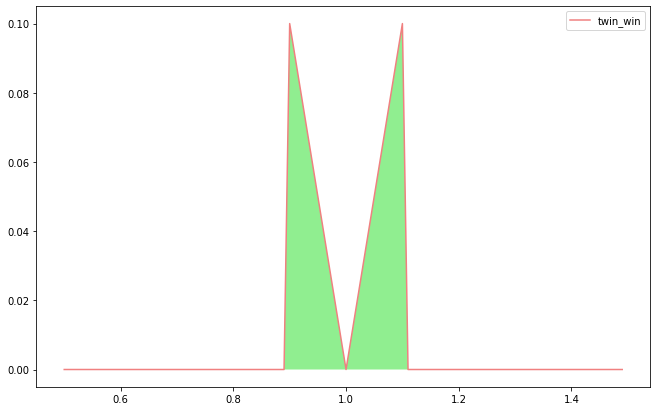

In [245]:
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()
fig = plt.figure(figsize = (11,7))
axs = fig.subplots(1)
plugins.clear(fig)  # clear all plugins from the figure


leftmost = -0.5
rightmost = 0.5
step = 0.01
grid = np.arange(leftmost,rightmost,step)

upper_barrier = 1.1
lower_barrier = 0.9
twin_win_ = [Twin_Peaks_pcg(1+round(i,2), upper_barrier, lower_barrier) for i in grid]

# pnl = [i+j for i,j in zip(P_entry*grid, straddle)]

axs.plot(grid+1, twin_win_, c='lightcoral',label='twin_win')

axs.fill_between(grid+1, 0, np.array(twin_win_), where=np.array(twin_win_) >= 0, facecolor='lightgreen', interpolate=True)
axs.fill_between(grid+1, 0, np.array(twin_win_), where=np.array(twin_win_) <= 0, facecolor='lightsalmon', interpolate=True)

axs.legend()
plugins.connect(fig, plugins.Reset(), plugins.BoxZoom(), plugins.Zoom())#, tooltip)
plt.show()


In [237]:
grid

array([-1.00000000e-01, -9.00000000e-02, -8.00000000e-02, -7.00000000e-02,
       -6.00000000e-02, -5.00000000e-02, -4.00000000e-02, -3.00000000e-02,
       -2.00000000e-02, -1.00000000e-02, -5.55111512e-17,  1.00000000e-02,
        2.00000000e-02,  3.00000000e-02,  4.00000000e-02,  5.00000000e-02,
        6.00000000e-02,  7.00000000e-02,  8.00000000e-02,  9.00000000e-02,
        1.00000000e-01])

In [248]:
import plotly.express as px


leftmost = -0.3
rightmost = 0.3
step = 0.01
grid = np.arange(leftmost,rightmost,step)

upper_barrier = 1.1
lower_barrier = 0.9
twin_win_ = [Twin_Peaks_pcg(1+round(i,2), upper_barrier, lower_barrier) for i in grid]
df = pd.DataFrame({'results': twin_win_,
                  'price': grid+1})


fig = px.line(df, x="price", y="results", title="Twin Win")
fig.update_yaxes(
    scaleratio = 100
)
fig.update_traces(mode="markers+lines")

fig.show()

## Highland

In [13]:
def Highland(week, upper_barrier, lower_barrier, P_last, bonus_coupon, style):
    if style == 'american':
        for P in week['close']:
            bad_condition_up = P > upper_barrier
            bad_condition_down = P < lower_barrier
            if bad_condition_up | bad_condition_down:
                return 0
    if (P_last > upper_barrier) | (P_last < lower_barrier):
        return 0
    else:
        return bonus_coupon

In [14]:
def Highland_backtest(data_periods, parameters_period, style):
#     data_period = data_biweek_eth #data_months_eth
#     parameters_period = eth_15_ascent_parameters #eth_30_ascent_parameters
    periods_in_one_year = len(data_periods)#-1
    index = ['period_'+str(i) for i in range(len(data_periods))]
    other_parameters = ['Avg', 'Max', 'APY', 'APR', 'MAX_APY', 'MAX_APR']
    index += other_parameters
    columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]
    highland_period_results = pd.DataFrame(index=index, 
                          columns = columns)
    for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(parameters_period['Lower Barrier'],
                                                  parameters_period['Upper Barrier'],
                                                  parameters_period['Base Coupon'],
                                                  parameters_period['Bonus Coupon']):
        for i in range(len(data_periods)):
            period = data_periods[i]
            S_0=period['close'][0]
            lower_barrier=S_0*down_barrier
            upper_barrier=S_0*up_barrier
            if i<len(data_periods)-1:
                P_last = data_periods[i+1]['close'][0]
            else:
                P_last = period['close'][-1]
            period_performance_as_pcg = Highland(period, upper_barrier, lower_barrier, P_last, bonus_coupon, style)
            highland_period_results[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + period_performance_as_pcg) /periods_in_one_year
            # APR, APY
            print()
            highland_period_results[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = highland_period_results[str([down_barrier, up_barrier])].iloc[i] * periods_in_one_year
            highland_period_results[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (highland_period_results[str([down_barrier, up_barrier])].iloc[i] +1)** periods_in_one_year-1
    # Avg, Max, CumProd
#     highland_period_results.iloc[len(index)-3] = np.mean(highland_period_results)
#     highland_period_results.iloc[len(index)-2] = np.max(highland_period_results)
#     highland_period_results.iloc[len(index)-1] = (1+highland_period_results).cumprod().iloc[len(index)-4]
    
    highland_period_results.iloc[len(index)-len(other_parameters)] = np.mean(highland_period_results)
    highland_period_results.iloc[len(index)-len(other_parameters)+1] = np.max(highland_period_results)
    highland_period_results.iloc[len(index)-len(other_parameters)+2] = (1+highland_period_results).cumprod().iloc[len(index)-len(other_parameters)-1]
    highland_period_results.iloc[len(index)-len(other_parameters)+3] = 1+highland_period_results.cumsum().iloc[len(index)-len(other_parameters)-1]
    highland_period_results.iloc[len(index)-len(other_parameters)+4] = (highland_period_results.iloc[len(index)-len(other_parameters)+1]+1)** periods_in_one_year
    highland_period_results.iloc[len(index)-len(other_parameters)+5] = 1+highland_period_results.iloc[len(index)-len(other_parameters)+1]* periods_in_one_year
    return highland_period_results

## Corridor

In [15]:
def Corridor(period, upper_barrier, lower_barrier, bonus_coupon, period_len):
    n = 0
    for P in period['close']:
        if (lower_barrier < P) and (P < upper_barrier):
            n += 1
    return bonus_coupon * n/period_len

In [16]:
def Corridor_backtest(data_periods, parameters_period):
#     data_period = data_biweek_eth #data_months_eth
#     parameters_period = eth_15_ascent_parameters #eth_30_ascent_parameters
    index = ['period_'+str(i) for i in range(len(data_periods))]
    other_parameters = ['Avg', 'Max', 'APY', 'APR', 'MAX_APY', 'MAX_APR']
    index += other_parameters
    periods_in_one_year = len(data_periods) #-1
    columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(parameters_period['Lower Barrier'],
               parameters_period['Upper Barrier'])]
    corridor_period_results = pd.DataFrame(index=index, 
                          columns = columns)
    for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(parameters_period['Lower Barrier'],
                                                  parameters_period['Upper Barrier'],
                                                  parameters_period['Base Coupon'],
                                                  parameters_period['Bonus Coupon']):
        for i in range(len(data_periods)):
            period = data_periods[i]
            S_0=period['close'][0]
            lower_barrier=S_0*down_barrier
            upper_barrier=S_0*up_barrier
            period_performance_as_pcg = Corridor(period, upper_barrier, lower_barrier, bonus_coupon, len(period))
            corridor_period_results[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + period_performance_as_pcg) /periods_in_one_year
            # APR, APY
            corridor_period_results[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = corridor_period_results[str([down_barrier, up_barrier])].iloc[i] * periods_in_one_year
            corridor_period_results[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (corridor_period_results[str([down_barrier, up_barrier])].iloc[i] +1)** periods_in_one_year-1
    # Avg, Max, CumProd
    corridor_period_results.iloc[len(index)-len(other_parameters)] = np.mean(corridor_period_results)
    corridor_period_results.iloc[len(index)-len(other_parameters)+1] = np.max(corridor_period_results)
    corridor_period_results.iloc[len(index)-len(other_parameters)+2] = (1+corridor_period_results).cumprod().iloc[len(index)-len(other_parameters)-1]
    corridor_period_results.iloc[len(index)-len(other_parameters)+3] = 1+corridor_period_results.cumsum().iloc[len(index)-len(other_parameters)-1]
    corridor_period_results.iloc[len(index)-len(other_parameters)+4] = (corridor_period_results.iloc[len(index)-len(other_parameters)+1]+1)** periods_in_one_year
    corridor_period_results.iloc[len(index)-len(other_parameters)+5] = 1+corridor_period_results.iloc[len(index)-len(other_parameters)+1]* periods_in_one_year
    return corridor_period_results

In [124]:
corridor_period_results=Corridor_backtest(data_30days_eth_2022, eth_30_corridor_parameters)

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [126]:
corridor_period_results

,"[0.98, 1.02]","[0.96, 1.04]","[0.94, 1.06]","[0.92, 1.08]","[0.98, 1.02]_APR","[0.96, 1.04]_APR","[0.94, 1.06]_APR","[0.92, 1.08]_APR","[0.98, 1.02]_APY","[0.96, 1.04]_APY","[0.94, 1.06]_APY","[0.92, 1.08]_APY"
period_0,0.00216,0.001144,0.000827,0.00081,0.025926,0.013725,0.009929,0.009722,0.026236,0.013812,0.009974,0.009766
period_1,0.00216,0.003431,0.002896,0.002593,0.025926,0.041176,0.034752,0.031111,0.026236,0.041963,0.035311,0.031559
period_2,0.002701,0.002288,0.002482,0.002269,0.032407,0.027451,0.029787,0.027222,0.032893,0.027799,0.030197,0.027564
period_3,0.002701,0.00143,0.001241,0.001458,0.032407,0.017157,0.014894,0.0175,0.032893,0.017292,0.014996,0.017641
period_4,0.00162,0.001144,0.001241,0.001134,0.019444,0.013725,0.014894,0.013611,0.019619,0.013812,0.014996,0.013696
period_5,0.00054,0.000286,0.000621,0.001458,0.006481,0.003431,0.007447,0.0175,0.006501,0.003437,0.007472,0.017641
period_6,0.00216,0.001716,0.001655,0.001458,0.025926,0.020588,0.019858,0.0175,0.026236,0.020784,0.02004,0.017641
period_7,0.003781,0.003145,0.003517,0.002917,0.04537,0.037745,0.042199,0.035,0.046326,0.038405,0.043024,0.035567
period_8,0.004321,0.002574,0.003103,0.002593,0.051852,0.030882,0.037234,0.031111,0.053102,0.031323,0.037876,0.031559
period_9,0.008102,0.006577,0.005585,0.004375,0.097222,0.078922,0.067021,0.0525,0.101674,0.08184,0.069119,0.053782


## Results to excel

In [17]:
ascent_eth_7_2021_european = convert_to_pcg(Ascent_backtest(data_30days_eth_2021, eth_7_ascent_parameters_eur, 'european'))
ascent_eth_7_2022_european = convert_to_pcg(Ascent_backtest(data_30days_eth_2022, eth_7_ascent_parameters_eur, 'european'))

ascent_eth_7_2021_american = convert_to_pcg(Ascent_backtest(data_30days_eth_2021, eth_7_ascent_parameters_amer, 'american'))
ascent_eth_7_2022_american = convert_to_pcg(Ascent_backtest(data_30days_eth_2022, eth_7_ascent_parameters_amer, 'american'))

ascent_btc_7_2021_european = convert_to_pcg(Ascent_backtest(data_30days_btc_2021, btc_7_ascent_parameters_eur, 'european'))
ascent_btc_7_2022_european = convert_to_pcg(Ascent_backtest(data_30days_btc_2022, btc_7_ascent_parameters_eur, 'european'))

ascent_btc_7_2021_american = convert_to_pcg(Ascent_backtest(data_30days_btc_2021, btc_7_ascent_parameters_amer, 'american'))
ascent_btc_7_2022_american = convert_to_pcg(Ascent_backtest(data_30days_btc_2022, btc_7_ascent_parameters_amer, 'american'))


twin_win_eth_7_2021_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_7_twin_win_parameters_eur, 'european'))
twin_win_eth_7_2022_european = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_7_twin_win_parameters_eur, 'european'))

twin_win_eth_7_2021_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2021, eth_7_twin_win_parameters_amer, 'american'))
twin_win_eth_7_2022_american = convert_to_pcg(Twin_win_backtest(data_30days_eth_2022, eth_7_twin_win_parameters_amer, 'american'))

twin_win_btc_7_2021_european = convert_to_pcg(Twin_win_backtest(data_30days_btc_2021, btc_7_twin_win_parameters_eur, 'european'))
twin_win_btc_7_2022_european = convert_to_pcg(Twin_win_backtest(data_30days_btc_2022, btc_7_twin_win_parameters_eur, 'european'))

twin_win_btc_7_2021_american = convert_to_pcg(Twin_win_backtest(data_30days_btc_2021, btc_7_twin_win_parameters_amer, 'american'))
twin_win_btc_7_2022_american = convert_to_pcg(Twin_win_backtest(data_30days_btc_2022, btc_7_twin_win_parameters_amer, 'american'))


highland_eth_7_2021_european = convert_to_pcg(Highland_backtest(data_30days_eth_2021, eth_7_highland_parameters_eur, 'european'))
highland_eth_7_2022_european = convert_to_pcg(Highland_backtest(data_30days_eth_2022, eth_7_highland_parameters_eur, 'european'))

highland_eth_7_2021_american = convert_to_pcg(Highland_backtest(data_30days_eth_2021, eth_7_highland_parameters_amer, 'american'))
highland_eth_7_2022_american = convert_to_pcg(Highland_backtest(data_30days_eth_2022, eth_7_highland_parameters_amer, 'american'))

highland_btc_7_2021_european = convert_to_pcg(Highland_backtest(data_30days_btc_2021, btc_7_highland_parameters_eur, 'european'))
highland_btc_7_2022_european = convert_to_pcg(Highland_backtest(data_30days_btc_2022, btc_7_highland_parameters_eur, 'european'))

highland_btc_7_2021_american = convert_to_pcg(Highland_backtest(data_30days_btc_2021, btc_7_highland_parameters_amer, 'american'))
highland_btc_7_2022_american = convert_to_pcg(Highland_backtest(data_30days_btc_2022, btc_7_highland_parameters_amer, 'american'))


corridor_eth_7_2021 = convert_to_pcg(Corridor_backtest(data_30days_eth_2021, eth_7_corridor_parameters))
corridor_eth_7_2022 = convert_to_pcg(Corridor_backtest(data_30days_eth_2022, eth_7_corridor_parameters))

corridor_btc_7_2021 = convert_to_pcg(Corridor_backtest(data_30days_btc_2021, btc_7_corridor_parameters))
corridor_btc_7_2022 = convert_to_pcg(Corridor_backtest(data_30days_btc_2022, btc_7_corridor_parameters))

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/li

In [183]:
ascent_btc_7_2021_american = convert_to_pcg(Ascent_backtest(data_7days_btc_2021, btc_7_ascent_parameters_amer, 'american'))
ascent_btc_7_2022_american = convert_to_pcg(Ascent_backtest(data_7days_btc_2022, btc_7_ascent_parameters_amer, 'american'))


twin_win_btc_7_2021_american = convert_to_pcg(Twin_win_backtest(data_7days_btc_2021, btc_7_twin_win_parameters_amer, 'american'))
twin_win_btc_7_2022_american = convert_to_pcg(Twin_win_backtest(data_7days_btc_2022, btc_7_twin_win_parameters_amer, 'american'))


highland_btc_7_2021_american = convert_to_pcg(Highland_backtest(data_7days_btc_2021, btc_7_highland_parameters_amer, 'american'))
highland_btc_7_2022_american = convert_to_pcg(Highland_backtest(data_7days_btc_2022, btc_7_highland_parameters_amer, 'american'))

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/li

KeyError: 'period_0'

In [178]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Results_2%_base.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
ascent_eth_7_2021_american.to_excel(writer, sheet_name='Ascent_7_2021_eth_american')
ascent_eth_7_2022_american.to_excel(writer, sheet_name='Ascent_7_2022_eth_american')
twin_win_eth_7_2021_american.to_excel(writer, sheet_name='Twin_win_7_2021_eth_american')
twin_win_eth_7_2022_american.to_excel(writer, sheet_name='Twin_win_7_2022_eth_american')
highland_eth_7_2021_american.to_excel(writer, sheet_name='Highland_7_2021_eth_american')
highland_eth_7_2022_american.to_excel(writer, sheet_name='Highaland_7_2022_eth_american')
writer.close()

In [25]:
# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('Results/twin_win_eth.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# twin_win_eth_7_2021_european.to_excel(writer, sheet_name='7_2021_eth_european')
# twin_win_eth_7_2022_european.to_excel(writer, sheet_name='7_2022_eth_european')
# twin_win_eth_7_2021_american.to_excel(writer, sheet_name='7_2021_eth_american')
# twin_win_eth_7_2022_american.to_excel(writer, sheet_name='7_2022_eth_american')
# twin_win_eth_15_2021_european.to_excel(writer, sheet_name='15_2021_eth_european')
# twin_win_eth_15_2022_european.to_excel(writer, sheet_name='15_2022_eth_european')
# twin_win_eth_15_2021_american.to_excel(writer, sheet_name='15_2021_eth_american')
# twin_win_eth_15_2022_american.to_excel(writer, sheet_name='15_2022_eth_american')
# twin_win_eth_30_2021_european.to_excel(writer, sheet_name='30_2021_eth_european')
# twin_win_eth_30_2022_european.to_excel(writer, sheet_name='30_2022_eth_european')
# twin_win_eth_30_2021_american.to_excel(writer, sheet_name='30_2021_eth_american')
# twin_win_eth_30_2022_american.to_excel(writer, sheet_name='30_2022_eth_american')

# writer.close()

# writer = pd.ExcelWriter('Results/twin_win_btc.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# twin_win_btc_7_2021_european.to_excel(writer, sheet_name='7_2021_btc_european')
# twin_win_btc_7_2022_european.to_excel(writer, sheet_name='7_2022_btc_european')
# twin_win_btc_7_2021_american.to_excel(writer, sheet_name='7_2021_btc_american')
# twin_win_btc_7_2022_american.to_excel(writer, sheet_name='7_2022_btc_american')
# twin_win_btc_15_2021_european.to_excel(writer, sheet_name='15_2021_btc_european')
# twin_win_btc_15_2022_european.to_excel(writer, sheet_name='15_2022_btc_european')
# twin_win_btc_15_2021_american.to_excel(writer, sheet_name='15_2021_btc_american')
# twin_win_btc_15_2022_american.to_excel(writer, sheet_name='15_2022_btc_american')
# twin_win_btc_30_2021_european.to_excel(writer, sheet_name='30_2021_btc_european')
# twin_win_btc_30_2022_european.to_excel(writer, sheet_name='30_2022_btc_european')
# twin_win_btc_30_2021_american.to_excel(writer, sheet_name='30_2021_btc_american')
# twin_win_btc_30_2022_american.to_excel(writer, sheet_name='30_2022_btc_american')

# writer.close()

In [165]:
dfs_eth_ascent = [ascent_eth_7_2021_european, ascent_eth_7_2021_american,
              ascent_eth_7_2022_european, ascent_eth_7_2022_american,
              ascent_eth_15_2021_european, ascent_eth_15_2021_american,
              ascent_eth_15_2022_european, ascent_eth_15_2022_american,
              ascent_eth_30_2021_european, ascent_eth_30_2021_american,
              ascent_eth_30_2022_european, ascent_eth_30_2022_american,
      ]
dfs_btc_ascent = [ascent_btc_7_2021_european, ascent_btc_7_2021_american,
              ascent_btc_7_2022_european, ascent_btc_7_2022_american,
              ascent_btc_15_2021_european, ascent_btc_15_2021_american,
              ascent_btc_15_2022_european, ascent_btc_15_2022_american,
              ascent_btc_30_2021_european, ascent_btc_30_2021_american,
              ascent_btc_30_2022_european, ascent_btc_30_2022_american,
      ]


dfs_eth_twin_win = [twin_win_eth_7_2021_european, twin_win_eth_7_2021_american,
              twin_win_eth_7_2022_european, twin_win_eth_7_2022_american,
              twin_win_eth_15_2021_european, twin_win_eth_15_2021_american,
              twin_win_eth_15_2022_european, twin_win_eth_15_2022_american,
              twin_win_eth_30_2021_european, twin_win_eth_30_2021_american,
              twin_win_eth_30_2022_european, twin_win_eth_30_2022_american,
      ]
dfs_btc_twin_win = [twin_win_btc_7_2021_european, twin_win_btc_7_2021_american,
              twin_win_btc_7_2022_european, twin_win_btc_7_2022_american,
              twin_win_btc_15_2021_european, twin_win_btc_15_2021_american,
              twin_win_btc_15_2022_european, twin_win_btc_15_2022_american,
              twin_win_btc_30_2021_european, twin_win_btc_30_2021_american,
              twin_win_btc_30_2022_european, twin_win_btc_30_2022_american,]


dfs_eth_highland = [highland_eth_7_2021_european, highland_eth_7_2021_american,
              highland_eth_7_2022_european, highland_eth_7_2022_american,
              highland_eth_15_2021_european, highland_eth_15_2021_american,
              highland_eth_15_2022_european, highland_eth_15_2022_american,
              highland_eth_30_2021_european, highland_eth_30_2021_american,
              highland_eth_30_2022_european, highland_eth_30_2022_american,
      ]
dfs_btc_highland = [highland_btc_7_2021_european, highland_btc_7_2021_american,
              highland_btc_7_2022_european, highland_btc_7_2022_american,
              highland_btc_15_2021_european, highland_btc_15_2021_american,
              highland_btc_15_2022_european, highland_btc_15_2022_american,
              highland_btc_30_2021_european, highland_btc_30_2021_american,
              highland_btc_30_2022_european, highland_btc_30_2022_american,
      ]



dfs_eth_corridor = [corridor_eth_7_2021, corridor_eth_7_2022,
              corridor_eth_15_2021, corridor_eth_15_2022,
              corridor_eth_30_2021, corridor_eth_30_2022,
      ]
dfs_btc_corridor = [corridor_btc_7_2021, corridor_btc_7_2022,
              corridor_btc_15_2021, corridor_btc_15_2022,
              corridor_btc_30_2021, corridor_btc_30_2022,
      ]

In [166]:
dfs_results_eth = [dfs_eth_ascent,
                  dfs_eth_twin_win,
                  dfs_eth_highland,
                  dfs_eth_corridor]
dfs_results_btc = [dfs_btc_ascent,
                  dfs_btc_twin_win,
                  dfs_btc_highland,
                  dfs_btc_corridor]

In [167]:
strategies = ['Ascent', 'Twin Win', 'Highland', 'Corridor']
year_style_stgies = ['2021_european', '2021_american','2022_european','2022_american']
writer = pd.ExcelWriter("Results.xlsx", engine="xlsxwriter")
for i in range(len(strategies)-1):
    strategy = strategies[i]
    startrow = 4
    j = 0
#     print(len(dfs_results_eth[i]))
    for df_eth, df_btc in zip(dfs_results_eth[i], dfs_results_btc[i]):
        # Write dfs
        df_eth.to_excel(writer, sheet_name=strategy, startrow=startrow)
        df_btc.to_excel(writer, sheet_name=strategy, startrow=startrow, startcol=12+8)
#         print(i)
#         print(df_eth)
        # Add descriptions
        len_period = len(df_eth.index) - 6
        worksheet = writer.sheets[strategy]
        worksheet.write(startrow - 3, 0, 
                        'ETH_'+str(int(365/len_period))+'days_'+year_style_stgies[j % 4])
        worksheet.write(startrow - 3, 12+8,
                        'BTC_'+str(int(365/len_period))+'days_'+year_style_stgies[j % 4])
        
        # Increasi row number and j for next iteration
        startrow += (len(df_eth.index) + 6)
        j += 1

# We treat Corridor separatelly
year_style_corridor = ['2021', '2022']
startrow = 4
j = 0
for df_eth, df_btc in zip(dfs_results_eth[3], dfs_results_btc[3]):
        # Write dfs
        df_eth.to_excel(writer, sheet_name=strategies[3], startrow=startrow)
        df_btc.to_excel(writer, sheet_name=strategies[3], startrow=startrow, startcol=12+8)
        # Add descriptions
        len_period = len(df_eth.index) - 6
        worksheet = writer.sheets[strategies[3]]
        worksheet.write(startrow - 3, 0, 
                        'ETH_'+str(int(365/len_period))+'days_'+year_style_corridor[j % 2])
        worksheet.write(startrow - 3, 12+8,
                        'BTC_'+str(int(365/len_period))+'days_'+year_style_corridor[j % 2])
        
        # Increasi row number and j for next iteration
        startrow += (len(df_eth.index) + 6)
        j += 1
writer.close()

# TRASH

### Ascent

In [41]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['month_'+str(i) for i in range(len(data_months_btc))]+['Avg', 'Max', 'CumProd']
index_parameters = list(btc_ascent_parameters.index)
columns = [str([strike, barrier]) for strike,barrier in 
           zip(btc_ascent_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_ascent_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([strike, barrier])+'_APR' for strike,barrier in 
           zip(btc_ascent_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_ascent_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([strike, barrier])+'_APY' for strike,barrier in 
           zip(btc_ascent_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_ascent_parameters['Upper Barrier'].loc[index_parameters[-1:]])]
ascent_btc = pd.DataFrame(index=index, 
                      columns = columns)
# for strike, barrier, coupon, part_rate in zip(btc_ascent_parameters['Lower Barrier'],
#                                               btc_ascent_parameters['Upper Barrier'],
#                                               btc_ascent_parameters['Base Coupon'],
#                                               btc_ascent_parameters['Participation Rate']):
for strike, barrier, coupon, part_rate in zip(btc_ascent_parameters['Lower Barrier'].loc[index_parameters[-1:]],
                                              btc_ascent_parameters['Upper Barrier'].loc[index_parameters[-1:]],
                                              btc_ascent_parameters['Base Coupon'].loc[index_parameters[-1:]],
                                              btc_ascent_parameters['Participation Rate'].loc[index_parameters[-1:]]):
#     for i in range(len(data_weeks_btc)):
    for i in range(len(data_months_btc)):
        month = data_months_btc[i]
        S_0=month['close'][0]
        strike_price=S_0*strike
        upper_barrier=S_0*barrier
        if i<len(data_months_btc)-1:
            P_last = data_months_btc[i+1]['close'][0]
        else:
            P_last = month['close'][-1]
        month_performance_as_pcg = Ascent(month, upper_barrier, strike_price, P_last, 'european')
    #         print(strike, barrier, coupon, part_rate)
    #         print(S_0, P_last, upper_barrier, strike_price)
    #         print(week_performance_as_pcg)
        ascent_btc[str([strike, barrier])].iloc[i] = (coupon + month_performance_as_pcg * part_rate) /12#/52
        # APR, APY
        ascent_btc[str([strike, barrier]) + '_APR'].iloc[i] = ascent_btc[str([strike, barrier])].iloc[i] *12#* 52
        ascent_btc[str([strike, barrier]) + '_APY'].iloc[i] = (ascent_btc[str([strike, barrier])].iloc[i] +1)**12-1#** 52-1
# Avg, Max, CumProd
ascent_btc.iloc[len(index)-3] = np.mean(ascent_btc)
ascent_btc.iloc[len(index)-2] = np.max(ascent_btc)
ascent_btc.iloc[len(index)-1] = (1+ascent_btc).cumprod().iloc[12]#.iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [9]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['week_'+str(i) for i in range(len(data_weeks_eth))]+['Avg', 'Max', 'CumProd']
columns = [str([strike, barrier]) for strike,barrier in 
           zip(eth_ascent_parameters['Lower Barrier'],
               eth_ascent_parameters['Upper Barrier'])]+[str([strike, barrier])+'_APR' for strike,barrier in 
           zip(eth_ascent_parameters['Lower Barrier'],
               eth_ascent_parameters['Upper Barrier'])]+[str([strike, barrier])+'_APY' for strike,barrier in 
           zip(eth_ascent_parameters['Lower Barrier'],
               eth_ascent_parameters['Upper Barrier'])]
ascent_eth = pd.DataFrame(index=index, 
                      columns = columns)
for strike, barrier, coupon, part_rate in zip(eth_ascent_parameters['Lower Barrier'],
                                              eth_ascent_parameters['Upper Barrier'],
                                              eth_ascent_parameters['Base Coupon'],
                                              eth_ascent_parameters['Participation Rate']):
    for i in range(len(data_weeks_eth)):
        week = data_weeks_eth[i]
        S_0=week['close'][0]
        strike_price=S_0*strike
        upper_barrier=S_0*barrier
        if i<len(data_weeks_eth)-1:
            P_last = data_weeks_eth[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
        week_performance_as_pcg = Ascent(week, upper_barrier, strike_price, P_last, 'european')
#         print(strike, barrier, coupon, part_rate)
#         print(S_0, P_last, upper_barrier, strike_price)
#         print(week_performance_as_pcg)
        ascent_eth[str([strike, barrier])].iloc[i] = (coupon + week_performance_as_pcg * part_rate) /52
        # APR, APY
        ascent_eth[str([strike, barrier]) + '_APR'].iloc[i] = ascent_eth[str([strike, barrier])].iloc[i] * 52
        ascent_eth[str([strike, barrier]) + '_APY'].iloc[i] = (ascent_eth[str([strike, barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
ascent_eth.iloc[len(index)-3] = np.mean(ascent_eth)
ascent_eth.iloc[len(index)-2] = np.max(ascent_eth)
ascent_eth.iloc[len(index)-1] = (1+ascent_eth).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [77]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['week_'+str(i) for i in range(len(data_weeks_btc))]+['Avg', 'Max', 'CumProd']
columns = [str([strike, barrier]) for strike,barrier in 
           zip(btc_ascent_parameters['Lower Barrier'],
               btc_ascent_parameters['Upper Barrier'])]+[str([strike, barrier])+'_APR' for strike,barrier in 
           zip(btc_ascent_parameters['Lower Barrier'],
               btc_ascent_parameters['Upper Barrier'])]+[str([strike, barrier])+'_APY' for strike,barrier in 
           zip(btc_ascent_parameters['Lower Barrier'],
               btc_ascent_parameters['Upper Barrier'])]
ascent_btc = pd.DataFrame(index=index, 
                      columns = columns)
for strike, barrier, coupon, part_rate in zip(btc_ascent_parameters['Lower Barrier'],
                                              btc_ascent_parameters['Upper Barrier'],
                                              btc_ascent_parameters['Base Coupon'],
                                              btc_ascent_parameters['Participation Rate']):
    for i in range(len(data_weeks_btc)):
        week = data_weeks_btc[i]
        S_0=week['close'][0]
        strike_price=S_0*strike
        upper_barrier=S_0*barrier
        if i<len(data_weeks_btc)-1:
            P_last = data_weeks_btc[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
        week_performance_as_pcg = Ascent(week, upper_barrier, strike_price, P_last, 'european')
#         print(strike, barrier, coupon, part_rate)
#         print(S_0, P_last, upper_barrier, strike_price)
#         print(week_performance_as_pcg)
        ascent_btc[str([strike, barrier])].iloc[i] = (coupon + week_performance_as_pcg * part_rate) /52
        # APR, APY
        ascent_btc[str([strike, barrier]) + '_APR'].iloc[i] = ascent_btc[str([strike, barrier])].iloc[i] * 52
        ascent_btc[str([strike, barrier]) + '_APY'].iloc[i] = (ascent_btc[str([strike, barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
ascent_btc.iloc[len(index)-3] = np.mean(ascent_btc)
ascent_btc.iloc[len(index)-2] = np.max(ascent_btc)
ascent_btc.iloc[len(index)-1] = (1+ascent_btc).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [109]:
# print("Simple interest cumulative: \n", 1+ascent[columns].iloc[:-2].dropna().cumsum().iloc[52])
print("Cumulative APY: \n", (1+ascent[columns].iloc[:-2].dropna()).cumprod().iloc[52])

Cumulative APY: 
 [0.98, 1.02]    1.019119
[0.96, 1.04]    1.021209
[0.94, 1.06]    1.029039
[0.92, 1.08]    1.031161
Name: week_52, dtype: object


In [108]:
(1+ascent.dropna()).cumprod().tail()

,"[0.98, 1.02]","[0.96, 1.04]","[0.94, 1.06]","[0.92, 1.08]","[0.98, 1.02]*52","[0.96, 1.04]*52","[0.94, 1.06]*52","[0.92, 1.08]*52"
week_50,1.018923,1.018648,1.027334,1.029727,1.289642,419.258911,53.841565,27.835704
week_51,1.019021,1.018746,1.027432,1.029826,1.296090,471.958187,58.218519,29.711716
week_52,1.019119,1.021209,1.029039,1.031161,1.302571,531.281564,62.951291,31.714164
Avg,1.019484,1.021613,1.029595,1.031759,1.309083,598.061667,68.068805,33.851569
Max,1.024277,1.024168,1.031834,1.03371,1.315629,673.235780,73.602338,36.133026


In [289]:
# (1+shark_fin_apy.dropna()).mean()
print("Average:\n",(ascent.dropna().mean()+1)**52-1)
print("\n")
# print("Max compound:\n", (ascent.dropna().max()+1)**52-1)
print("Max simple:\n", ascent.dropna().max()*52)

Average:
 4.0%    0.033819
dtype: float64


Max simple:
 4.0%    0.135844
dtype: object


In [139]:
0.13/52 # if price moved 9%, for 9% we got 0.26%

0.0025

In [144]:
list(ascent['4.0%']).index(float(ascent.dropna().max()))

40

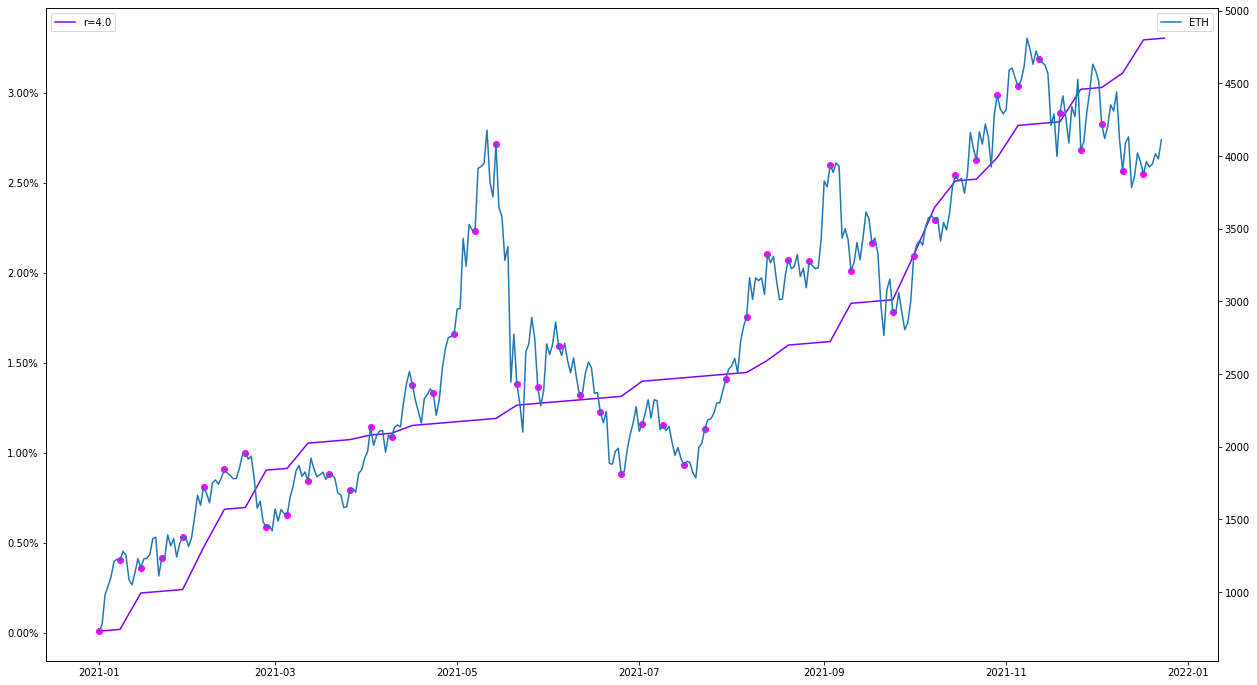

In [82]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
i = 52
data = data_eth
color = iter(cm.rainbow(np.linspace(0, 1, len(strikes))))
for strike in strikes:
# for apy in apys:
    c = next(color)
    axs.plot(list(data.index)[::7][:i], 
            (1+ascent[str(round(strike*100,3))+'%'])[:i].cumprod(),
            color=c, label='r='+str(round(strike*100,3)))
axs_=axs.twinx()
axs_.plot(list(data.index)[:7*(i-1)], 
        data['close'][:7*(i-1)],
        color='tab:blue', label='ETH')

axs_.scatter(list(data.index)[:7*(i-1):7], 
        data['close'][:7*(i-1):7],
        color='magenta')
xticks_axs_=axs.get_xticks()
# axs_.axhline(y=data['close'][:7*(i-1):7][1]*upper_pcg, 
# #              xmin=xticks_axs_[0], 
# #              xmax=xticks_axs_[2], 
#              linestyle='dashed')
# axs_.axhline(y=data['close'][:7*(i-1):7][1]*down_pcg, 
# #              xmin=list(data.index)[:7*(i-1):7][1], 
# #              xmax=list(data.index)[:7*(i-1):7][2], 
#              linestyle='dashed')
    
axs.legend(loc='upper left')
axs_.legend(loc='upper right')

# manipulate
# vals = axs.get_yticks()
# axs.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

### Twin win

In [44]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['month_'+str(i) for i in range(len(data_months_eth))]+['Avg', 'Max', 'CumProd']
index_parameters = list(eth_twin_win_parameters.index) 
columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(eth_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               eth_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(eth_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               eth_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(eth_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               eth_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]])]
twin_win_eth = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, coupon, part_rate in zip(eth_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
                                              eth_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]],
                                              eth_twin_win_parameters['Base Coupon'].loc[index_parameters[-1:]],
                                              eth_twin_win_parameters['Participation Rate'].loc[index_parameters[-1:]]):
#     for i in range(len(data_weeks_btc)):
    for i in range(len(data_months_eth)):
        month = data_months_eth[i]
        S_0=month['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        
        if i<len(data_months_eth)-1:
            P_last = data_months_eth[i+1]['close'][0]
        else:
            P_last = month['close'][-1]
            
        month_performance_as_pcg = Twin_Peaks(month, upper_barrier, lower_barrier, P_last, 'european')
        twin_win_eth[str([down_barrier, up_barrier])].iloc[i] = (coupon + month_performance_as_pcg * part_rate) /12
        # APR, APY
        twin_win_eth[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = twin_win_eth[str([down_barrier, up_barrier])].iloc[i] * 12
        twin_win_eth[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (twin_win_eth[str([down_barrier, up_barrier])].iloc[i] +1)** 12-1
# Avg, Max, CumProd
twin_win_eth.iloc[len(index)-3] = np.mean(twin_win_eth)
twin_win_eth.iloc[len(index)-2] = np.max(twin_win_eth)
twin_win_eth.iloc[len(index)-1] = (1+twin_win_eth).cumprod().iloc[12]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [45]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['month_'+str(i) for i in range(len(data_months_btc))]+['Avg', 'Max', 'CumProd']
index_parameters = list(btc_twin_win_parameters.index) 
columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(btc_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(btc_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(btc_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]])]
twin_win_btc = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, coupon, part_rate in zip(btc_twin_win_parameters['Lower Barrier'].loc[index_parameters[-1:]],
                                              btc_twin_win_parameters['Upper Barrier'].loc[index_parameters[-1:]],
                                              btc_twin_win_parameters['Base Coupon'].loc[index_parameters[-1:]],
                                              btc_twin_win_parameters['Participation Rate'].loc[index_parameters[-1:]]):
#     for i in range(len(data_weeks_btc)):
    for i in range(len(data_months_btc)):
        month = data_months_btc[i]
        S_0=month['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        
        if i<len(data_months_btc)-1:
            P_last = data_months_btc[i+1]['close'][0]
        else:
            P_last = month['close'][-1]
            
        month_performance_as_pcg = Twin_Peaks(month, upper_barrier, lower_barrier, P_last, 'european')
        twin_win_btc[str([down_barrier, up_barrier])].iloc[i] = (coupon + month_performance_as_pcg * part_rate) /12
        # APR, APY
        twin_win_btc[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = twin_win_btc[str([down_barrier, up_barrier])].iloc[i] * 12
        twin_win_btc[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (twin_win_btc[str([down_barrier, up_barrier])].iloc[i] +1)** 12-1
# Avg, Max, CumProd
twin_win_btc.iloc[len(index)-3] = np.mean(twin_win_btc)
twin_win_btc.iloc[len(index)-2] = np.max(twin_win_btc)
twin_win_btc.iloc[len(index)-1] = (1+twin_win_btc).cumprod().iloc[12]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Weekly results

In [15]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['week_'+str(i) for i in range(len(data_weeks_eth))]+['Avg', 'Max', 'CumProd']
columns = [str([down_barrier, up_barrier]) for down_barrier,up_barrier in 
           zip(eth_twin_win_parameters['Lower Barrier'],
               eth_twin_win_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier,up_barrier in 
           zip(eth_twin_win_parameters['Lower Barrier'],
               eth_twin_win_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier,up_barrier in 
           zip(eth_twin_win_parameters['Lower Barrier'],
               eth_twin_win_parameters['Upper Barrier'])]
twin_win_eth = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, coupon, part_rate in zip(eth_twin_win_parameters['Lower Barrier'],
                                              eth_twin_win_parameters['Upper Barrier'],
                                              eth_twin_win_parameters['Base Coupon'],
                                              eth_twin_win_parameters['Participation Rate']):
    for i in range(len(data_weeks_eth)):
        week = data_weeks_eth[i]
        S_0=week['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        
        if i<len(data_weeks_eth)-1:
            P_last = data_weeks_eth[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
            
        week_performance_as_pcg = Twin_Peaks(week, upper_barrier, lower_barrier, P_last, 'european')
        twin_win_eth[str([down_barrier, up_barrier])].iloc[i] = (coupon + week_performance_as_pcg * part_rate) /52
        # APR, APY
        twin_win_eth[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = twin_win_eth[str([down_barrier, up_barrier])].iloc[i] * 52
        twin_win_eth[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (twin_win_eth[str([down_barrier, up_barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
twin_win_eth.iloc[len(index)-3] = np.mean(twin_win_eth)
twin_win_eth.iloc[len(index)-2] = np.max(twin_win_eth)
twin_win_eth.iloc[len(index)-1] = (1+twin_win_eth).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [16]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['week_'+str(i) for i in range(len(data_weeks_btc))]+['Avg', 'Max', 'CumProd']
columns = [str([down_barrier, up_barrier]) for down_barrier,up_barrier in 
           zip(btc_twin_win_parameters['Lower Barrier'],
               btc_twin_win_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier,up_barrier in 
           zip(btc_twin_win_parameters['Lower Barrier'],
               btc_twin_win_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier,up_barrier in 
           zip(btc_twin_win_parameters['Lower Barrier'],
               btc_twin_win_parameters['Upper Barrier'])]
twin_win_btc = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, coupon, part_rate in zip(btc_twin_win_parameters['Lower Barrier'],
                                              btc_twin_win_parameters['Upper Barrier'],
                                              btc_twin_win_parameters['Base Coupon'],
                                              btc_twin_win_parameters['Participation Rate']):
    for i in range(len(data_weeks_btc)):
        week = data_weeks_btc[i]
        S_0=week['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        
        if i<len(data_weeks_btc)-1:
            P_last = data_weeks_btc[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
            
        week_performance_as_pcg = Twin_Peaks(week, upper_barrier, lower_barrier, P_last, 'european')
        twin_win_btc[str([down_barrier, up_barrier])].iloc[i] = (coupon + week_performance_as_pcg * part_rate) /52
        # APR, APY
        twin_win_btc[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = twin_win_btc[str([down_barrier, up_barrier])].iloc[i] * 52
        twin_win_btc[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (twin_win_btc[str([down_barrier, up_barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
twin_win_btc.iloc[len(index)-3] = np.mean(twin_win_btc)
twin_win_btc.iloc[len(index)-2] = np.max(twin_win_btc)
twin_win_btc.iloc[len(index)-1] = (1+twin_win_btc).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [103]:
print("Simple interest cumulative: \n", 1+ascent[columns].iloc[:-2].dropna().cumsum().iloc[52])

Simple interest cumulative: 
 [0.98, 1.02]     1.01896
[0.96, 1.04]    1.021003
[0.94, 1.06]    1.028645
[0.92, 1.08]    1.030705
Name: week_52, dtype: object


In [277]:
print("Average:\n",(twin_peaks.dropna().mean()+1)**52-1)
print("\n")
# print("Max compound:\n", (twin_peaks.dropna().max()+1)**52-1)
print("Max simple:\n", twin_peaks.dropna().max()*52)

Average:
 10.0%    0.029337
dtype: float64


Max simple:
 10.0%    0.106255
dtype: object


# Ribbon comparison

In [136]:
# data
# data = btc_historical
data_eth_ribbon = pd.DataFrame(eth_prices).loc["2021-01-01":"2022-08-12"]
data_eth_backtest = pd.DataFrame(eth_prices).loc["2022-01-01":"2022-12-31"]
# Note that last dataset in each set of periods has a length of less than one expect for that period, 
# so is better to take all the periods except the last one. ie [:-1]

data_7days_eth_ribbon = [data_eth_ribbon[i:i+7] for i in range(len(data_eth_ribbon)) if i % 7 == 0][:-1]
data_7days_eth_backtest = [data_eth_backtest[i:i+7] for i in range(len(data_eth_backtest)) if i % 7 == 0][:-1]

In [11]:
eth_prices

timestamp
2021-01-01     730.92
2021-01-02     775.28
2021-01-03     980.14
2021-01-04    1042.23
2021-01-05    1103.01
               ...   
2023-02-04    1666.39
2023-02-05    1629.45
2023-02-06    1614.42
2023-02-07     1671.0
2023-02-08    1679.47
Name: close, Length: 769, dtype: object

In [13]:
data_7days_backtest

[              close
 timestamp          
 2021-01-01   730.92
 2021-01-02   775.28
 2021-01-03   980.14
 2021-01-04  1042.23
 2021-01-05  1103.01
 2021-01-06  1211.47
 2021-01-07  1225.91,
               close
 timestamp          
 2021-01-08  1217.89
 2021-01-09  1280.39
 2021-01-10  1254.59
 2021-01-11   1087.2
 2021-01-12  1049.35
 2021-01-13  1129.88
 2021-01-14  1230.35,
               close
 timestamp          
 2021-01-15  1168.37
 2021-01-16  1227.88
 2021-01-17  1232.24
 2021-01-18  1258.89
 2021-01-19  1367.07
 2021-01-20  1377.58
 2021-01-21   1110.6,
               close
 timestamp          
 2021-01-22   1234.0
 2021-01-23  1234.53
 2021-01-24  1393.92
 2021-01-25  1317.77
 2021-01-26   1367.0
 2021-01-27  1240.98
 2021-01-28  1332.63,
               close
 timestamp          
 2021-01-29   1380.3
 2021-01-30  1379.79
 2021-01-31  1313.69
 2021-02-01  1374.72
 2021-02-02  1513.29
 2021-02-03  1666.43
 2021-02-04  1597.02,
               close
 timestamp          
 2021-02

In [137]:
# eth_7_twin_win_parameters_eur.loc[11]['Base Coupon'] = 0.04
eth_7_twin_win_parameters_eur.loc[11]['Base Coupon'] = 0.04
eth_7_twin_win_parameters_eur.loc[11]['Participation Rate'] = 1.59
eth_7_twin_win_parameters_eur, eth_7_twin_win_parameters_amer

(         eth Lower Barrier Upper Barrier Base Coupon Participation Rate  \
 8   Twin Win          0.98          1.02       0.005                 13   
 9        NaN          0.96          1.04       0.005               3.75   
 10       NaN          0.94          1.06       0.005                1.9   
 11       NaN          0.92          1.08        0.04               1.59   
 12       NaN           0.9           1.1       0.005               0.85   
 
    Bonus Coupon Max APR  
 8          0.26   0.265  
 9          0.15   0.155  
 10        0.114   0.119  
 11        0.108   0.113  
 12        0.085    0.09  ,
          eth Lower Barrier Upper Barrier Base Coupon Participation Rate  \
 8   Twin Win          0.94          1.06       0.005           7.608696   
 9        NaN          0.92          1.08       0.005           3.181818   
 10       NaN           0.9           1.1       0.005           1.785714   
 11       NaN          0.88          1.12       0.005           1.346154   

In [139]:
eth_7_twin_win_parameters_eur.loc[11:11]

,eth,Lower Barrier,Upper Barrier,Base Coupon,Participation Rate,Bonus Coupon,Max APR
11,NaN,0.92,1.08,0.04,1.59,0.108,0.113


In [148]:
data_periods = data_7days_eth_backtest#data_7days_eth_ribbon#data_7days_backtest###
parameters_period = eth_7_twin_win_parameters_eur.loc[11:11]
style = 'american'
# style = 'european'
index = ['week_'+str(i) for i in range(len(data_periods))]
other_parameters = ['Avg', 'Max', 'APY', 'APR', 'MAX_APY', 'MAX_APR']
index += other_parameters
periods_in_one_year = 52#-1
# index_parameters = list(eth_30_ascent_parameters.index)
columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
       zip(parameters_period['Lower Barrier'],
           parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
       zip(parameters_period['Lower Barrier'],
           parameters_period['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
       zip(parameters_period['Lower Barrier'],
           parameters_period['Upper Barrier'])]
twin_win_eth_7_ribbon = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, coupon, part_rate in zip(parameters_period['Lower Barrier'],
                                              parameters_period['Upper Barrier'],
                                              parameters_period['Base Coupon'],
                                              parameters_period['Participation Rate']):
    for i in range(len(data_periods)):
        period = data_periods[i]
        S_0=period['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        if i<len(data_periods)-1:
            P_last = data_periods[i+1]['close'][0]
        else:
            P_last = period['close'][-1]
        period_performance_as_pcg = Twin_Peaks_period(period, upper_barrier, lower_barrier, P_last, style)
        twin_win_eth_7_ribbon[str([down_barrier, up_barrier])].iloc[i] = (coupon + period_performance_as_pcg * part_rate) /periods_in_one_year
        # APR, APY
        twin_win_eth_7_ribbon[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = twin_win_eth_7_ribbon[str([down_barrier, up_barrier])].iloc[i] * periods_in_one_year
        twin_win_eth_7_ribbon[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (twin_win_eth_7_ribbon[str([down_barrier, up_barrier])].iloc[i] +1)** periods_in_one_year-1
# Avg, Max, CumProd
#     twin_win_eth_7_ribbon.iloc[len(index)-3] = np.mean(twin_win_eth_7_ribbon)
#     twin_win_eth_7_ribbon.iloc[len(index)-2] = np.max(twin_win_eth_7_ribbon)
#     twin_win_eth_7_ribbon.iloc[len(index)-1] = (1+twin_win_eth_7_ribbon).cumprod().iloc[len(index)-4]

twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)] = np.mean(twin_win_eth_7_ribbon)
twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)+1] = np.max(twin_win_eth_7_ribbon)
twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)+2] = (1+twin_win_eth_7_ribbon).cumprod().iloc[len(index)-len(other_parameters)-1]
twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)+3] = 1+twin_win_eth_7_ribbon.cumsum().iloc[len(index)-len(other_parameters)-1]
twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)+4] = (twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)+1]+1)** periods_in_one_year
twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)+5] = 1+twin_win_eth_7_ribbon.iloc[len(index)-len(other_parameters)+1]* periods_in_one_year

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [156]:
twin_win_backtest

,"[0.92, 1.08]","[0.92, 1.08]_APR","[0.92, 1.08]_APY"
week_0,0.000769,0.04,0.040795
week_1,0.000769,0.04,0.040795
week_2,0.000769,0.04,0.040795
week_3,0.003187,0.165716,0.179927
week_4,0.000769,0.04,0.040795
week_5,0.001744,0.090686,0.094838
week_6,0.000769,0.04,0.040795
week_7,0.000941,0.048935,0.050128
week_8,0.002095,0.108929,0.114957
week_9,0.001913,0.099465,0.104474


In [123]:
base = 0.02
print('More than the base coupon: '+str(round(np.mean(twin_win_eth_7_ribbon['[0.92, 1.08]'][:len(data_periods)]>base/52)*100,3))+'%')
print('APY ribbons period: '+str(round((twin_win_eth_7_ribbon['[0.92, 1.08]'].iloc[len(data_periods)+2]-1)*100,3))+'%')

More than the base coupon: 54.808%
APY ribbons period: 13.442%


In [149]:
base = 0.04
print('More than the base coupon: '+str(round(np.mean(twin_win_backtest['[0.92, 1.08]'][:len(data_periods)]>base/52)*100,3))+'%')
print('APY cruize period: '+str(round((twin_win_backtest['[0.92, 1.08]'].iloc[len(data_periods)+2]-1)*100,3))+'%')

More than the base coupon: 48.077%
APY cruize period: 6.941%


In [114]:
base = 0.02
print('More than the base coupon: '+str(round(np.mean(twin_win_backtest['[0.92, 1.08]'][:len(data_periods)]>base/52)*100,3))+'%')
print('APY cruize period: '+str(round((twin_win_backtest['[0.92, 1.08]'].iloc[len(data_periods)+2]-1)*100,3))+'%')

More than the base coupon: 34.615%
APY cruize period: 8.329%


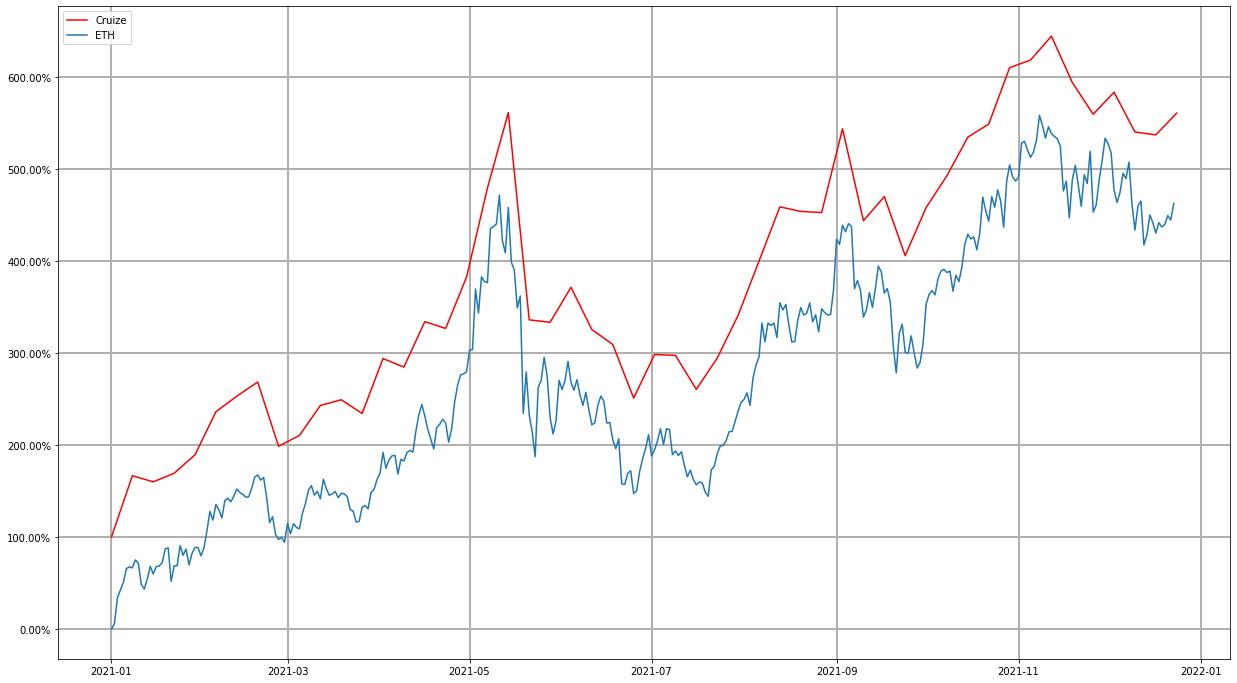

In [155]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
i = len(data_periods)
j = len(data_periods)
# j = 104
data = data_eth_ribbon#data_eth_backtest#
total_pnl_ribbon = [k+l for k,l in zip((1+twin_win_eth_7_ribbon['[0.92, 1.08]'])[:i].cumprod(),
                               data['close'][::7][:i]/data['close'][0])]
total_pnl_cruize = [k+l for k,l in zip((1+twin_win_eth_7_ribbon['[0.92, 1.08]'])[:j].cumprod(),
                               data['close'][::7][:j]/data['close'][0])]
    
# axs_=axs.twinx()
# axs.plot(list(data.index)[::7][:i], 
#         total_pnl_ribbon,
#         color='green', label='Ribbon')
axs.plot(list(data.index)[::7][:j], 
        total_pnl_cruize,
        color='red', label='Cruize')
axs.plot(list(data.index)[:7*(j-1)], 
#         data['close'][:7*(i-1)],
        data['close'][:7*(j-1)]/data['close'][0],  
        color='tab:blue', label='ETH')

# axs_.scatter(list(data.index)[:7*(i-1):7], 
#         data['close'][:7*(i-1):7],
#         color='magenta')
xticks_axs_=axs.get_xticks()
    
axs.legend(loc='upper left')
# axs_.legend(loc='upper right')
axs.grid(linewidth=2)
# manipulate
# vals = axs.get_yticks()
# axs.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
# axs_.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

In [150]:
list(data.index)[::7][:j]

[Timestamp('2021-01-01 00:00:00'),
 Timestamp('2021-01-08 00:00:00'),
 Timestamp('2021-01-15 00:00:00'),
 Timestamp('2021-01-22 00:00:00'),
 Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-02-05 00:00:00'),
 Timestamp('2021-02-12 00:00:00'),
 Timestamp('2021-02-19 00:00:00'),
 Timestamp('2021-02-26 00:00:00'),
 Timestamp('2021-03-05 00:00:00'),
 Timestamp('2021-03-12 00:00:00'),
 Timestamp('2021-03-19 00:00:00'),
 Timestamp('2021-03-26 00:00:00'),
 Timestamp('2021-04-02 00:00:00'),
 Timestamp('2021-04-09 00:00:00'),
 Timestamp('2021-04-16 00:00:00'),
 Timestamp('2021-04-23 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timestamp('2021-05-07 00:00:00'),
 Timestamp('2021-05-14 00:00:00'),
 Timestamp('2021-05-21 00:00:00'),
 Timestamp('2021-05-28 00:00:00'),
 Timestamp('2021-06-04 00:00:00'),
 Timestamp('2021-06-11 00:00:00'),
 Timestamp('2021-06-18 00:00:00'),
 Timestamp('2021-06-25 00:00:00'),
 Timestamp('2021-07-02 00:00:00'),
 Timestamp('2021-07-09 00:00:00'),
 Timestamp('2021-07-

In [56]:
data

[              close
 timestamp          
 2021-01-01   730.92
 2021-01-02   775.28
 2021-01-03   980.14
 2021-01-04  1042.23
 2021-01-05  1103.01
 2021-01-06  1211.47
 2021-01-07  1225.91,
               close
 timestamp          
 2021-01-08  1217.89
 2021-01-09  1280.39
 2021-01-10  1254.59
 2021-01-11   1087.2
 2021-01-12  1049.35
 2021-01-13  1129.88
 2021-01-14  1230.35,
               close
 timestamp          
 2021-01-15  1168.37
 2021-01-16  1227.88
 2021-01-17  1232.24
 2021-01-18  1258.89
 2021-01-19  1367.07
 2021-01-20  1377.58
 2021-01-21   1110.6,
               close
 timestamp          
 2021-01-22   1234.0
 2021-01-23  1234.53
 2021-01-24  1393.92
 2021-01-25  1317.77
 2021-01-26   1367.0
 2021-01-27  1240.98
 2021-01-28  1332.63,
               close
 timestamp          
 2021-01-29   1380.3
 2021-01-30  1379.79
 2021-01-31  1313.69
 2021-02-01  1374.72
 2021-02-02  1513.29
 2021-02-03  1666.43
 2021-02-04  1597.02,
               close
 timestamp          
 2021-02

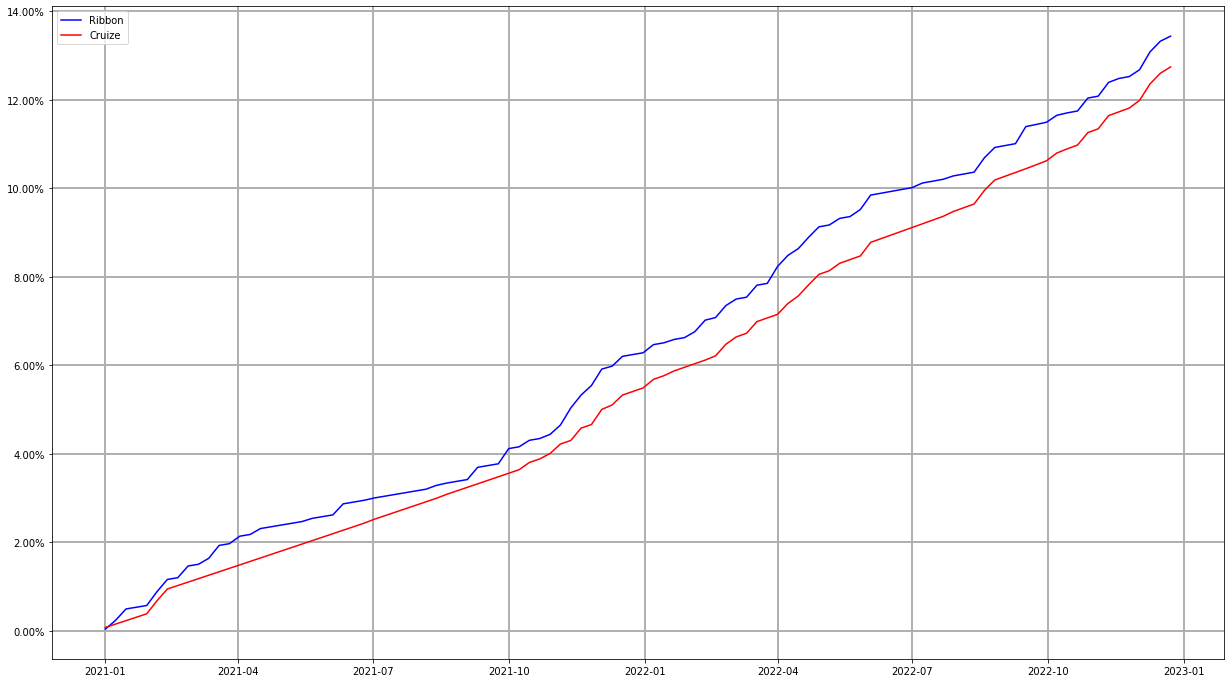

In [134]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
i = len(data_periods)
j = 104
data = data_eth_backtest#data_eth_ribbon
axs.plot(list(data.index)[::7][:i], 
        (1+twin_win_eth_7_ribbon['[0.92, 1.08]'])[:i].cumprod(),
        color='blue', label='Ribbon')
# axs_=axs.twinx()
axs.plot(list(data.index)[::7][:j], 
        (1+twin_win_backtest['[0.92, 1.08]'])[:j].cumprod(),
        color='red', label='Cruize')
    
axs.legend(loc='upper left')
# axs_.legend(loc='upper right')
axs.grid(linewidth=2)
# manipulate
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
# axs_.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

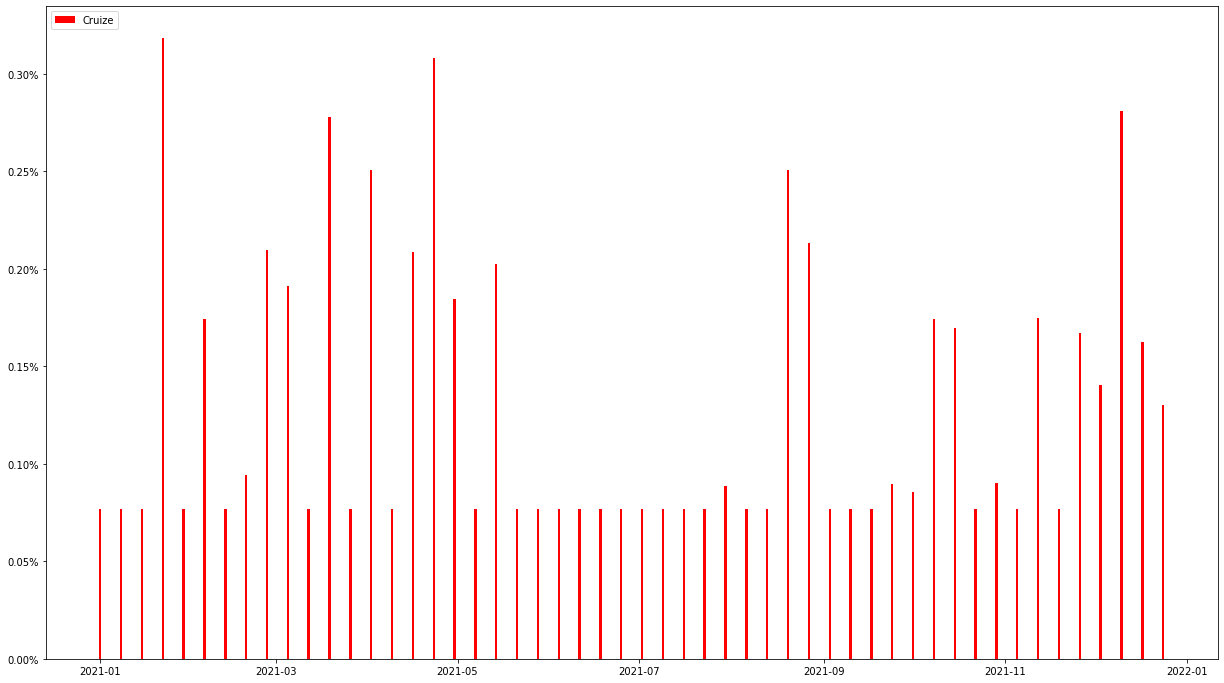

In [146]:
# fig, axs = plt.subplots(1, 1, figsize=(21, 7))
fig, axs = plt.subplots(1,1, figsize = (21,12))
j = 52
# axs.bar(list(data.index)[::7][:i], 
#         twin_win_eth_7_ribbon['[0.92, 1.08]'][:i],
#         color='blue', label='Ribbon')
axs.bar(list(data.index)[::7][:j], 
        twin_win_backtest['[0.92, 1.08]'][:j],
        color='red', label='Cruize')
axs.legend(loc='upper left')
plt.gca().set_yticklabels([f'{x:.2%}' for x in plt.gca().get_yticks()]) 
plt.show()
# plt.savefig('Files/foo.png')

In [147]:
twin_win_backtest['[0.92, 1.08]']

week_0     0.000769
week_1     0.000769
week_2     0.000769
week_3     0.003187
week_4     0.000769
week_5     0.001744
week_6     0.000769
week_7     0.000941
week_8     0.002095
week_9     0.001913
week_10    0.000769
week_11    0.002781
week_12    0.000769
week_13    0.002505
week_14    0.000769
week_15    0.002085
week_16    0.003084
week_17    0.001844
week_18    0.000769
week_19    0.002023
week_20    0.000769
week_21    0.000769
week_22    0.000769
week_23    0.000769
week_24    0.000769
week_25    0.000769
week_26    0.000769
week_27    0.000769
week_28    0.000769
week_29    0.000769
week_30    0.000888
week_31    0.000769
week_32    0.000769
week_33     0.00251
week_34    0.002135
week_35    0.000769
week_36    0.000769
week_37    0.000769
week_38    0.000898
week_39    0.000856
week_40    0.001742
week_41    0.001699
week_42    0.000769
week_43    0.000904
week_44    0.000769
week_45    0.001747
week_46    0.000769
week_47    0.001673
week_48    0.001407
week_49    0.002811


### Highland

In [48]:
index = ['month_'+str(i) for i in range(len(data_months_eth))]+['Avg', 'Max', 'CumProd']
index_parameters = list(eth_highland_parameters.index) 
columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(eth_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               eth_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(eth_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               eth_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(eth_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               eth_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]])]
highland_eth = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(eth_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
                                              eth_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]],
                                              eth_highland_parameters['Base Coupon'].loc[index_parameters[-1:]],
                                              eth_highland_parameters['Bonus Coupon'].loc[index_parameters[-1:]]):
    for i in range(len(data_months_eth)):
        month = data_months_eth[i]
        S_0=month['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        if i<len(data_months_eth)-1:
            P_last = data_months_eth[i+1]['close'][0]
        else:
            P_last = month['close'][-1]
        month_performance_as_pcg = Highland(month, upper_barrier, lower_barrier, P_last, bonus_coupon, 'european')
        highland_eth[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + month_performance_as_pcg) /12
#         print(base_coupon/12, month_performance_as_pcg/12, P_last/upper_barrier-1, P_last/lower_barrier-1)
        # APR, APY
        highland_eth[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = highland_eth[str([down_barrier, up_barrier])].iloc[i] * 12
        highland_eth[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (highland_eth[str([down_barrier, up_barrier])].iloc[i] +1)** 12-1
# Avg, Max, CumProd
highland_eth.iloc[len(index)-3] = np.mean(highland_eth)
highland_eth.iloc[len(index)-2] = np.max(highland_eth)
highland_eth.iloc[len(index)-1] = (1+highland_eth).cumprod().iloc[12]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [49]:
index = ['month_'+str(i) for i in range(len(data_months_btc))]+['Avg', 'Max', 'CumProd']
index_parameters = list(btc_highland_parameters.index) 
columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(btc_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(btc_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(btc_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]])]
highland_btc = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(btc_highland_parameters['Lower Barrier'].loc[index_parameters[-1:]],
                                              btc_highland_parameters['Upper Barrier'].loc[index_parameters[-1:]],
                                              btc_highland_parameters['Base Coupon'].loc[index_parameters[-1:]],
                                              btc_highland_parameters['Bonus Coupon'].loc[index_parameters[-1:]]):
    for i in range(len(data_months_btc)):
        month = data_months_btc[i]
        S_0=month['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        if i<len(data_months_btc)-1:
            P_last = data_months_btc[i+1]['close'][0]
        else:
            P_last = month['close'][-1]
        month_performance_as_pcg = Highland(month, upper_barrier, lower_barrier, P_last, bonus_coupon, 'european')
        highland_btc[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + month_performance_as_pcg) /12
#         print(base_coupon/12, month_performance_as_pcg/12, P_last/upper_barrier-1, P_last/lower_barrier-1)
        # APR, APY
        highland_btc[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = highland_btc[str([down_barrier, up_barrier])].iloc[i] * 12
        highland_btc[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (highland_btc[str([down_barrier, up_barrier])].iloc[i] +1)** 12-1
# Avg, Max, CumProd
highland_btc.iloc[len(index)-3] = np.mean(highland_btc)
highland_btc.iloc[len(index)-2] = np.max(highland_btc)
highland_btc.iloc[len(index)-1] = (1+highland_btc).cumprod().iloc[12]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [185]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['week_'+str(i) for i in range(len(data_weeks_eth))]+['Avg', 'Max', 'CumProd']
columns = [str([down_barrier, up_barrier]) for down_barrier,up_barrier in 
           zip(eth_highland_parameters['Lower Barrier'],
               eth_highland_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier,up_barrier in 
           zip(eth_highland_parameters['Lower Barrier'],
               eth_highland_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier,up_barrier in 
           zip(eth_highland_parameters['Lower Barrier'],
               eth_highland_parameters['Upper Barrier'])]
highland_eth = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(eth_highland_parameters['Lower Barrier'],
                                              eth_highland_parameters['Upper Barrier'],
                                              eth_highland_parameters['Base Coupon'],
                                              eth_highland_parameters['Bonus Coupon']):
    for i in range(len(data_weeks_eth)):
        week = data_weeks_eth[i]
        S_0=week['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        if i<len(data_weeks_eth)-1:
            P_last = data_weeks_eth[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
        week_performance_as_pcg = Highland(week, upper_barrier, lower_barrier, P_last, bonus_coupon, 'american')
        highland_eth[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + week_performance_as_pcg) /52
        # APR, APY
        highland_eth[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = highland_eth[str([down_barrier, up_barrier])].iloc[i] * 52
        highland_eth[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (highland_eth[str([down_barrier, up_barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
highland_eth.iloc[len(index)-3] = np.mean(highland_eth)
highland_eth.iloc[len(index)-2] = np.max(highland_eth)
highland_eth.iloc[len(index)-1] = (1+highland_eth).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [21]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['week_'+str(i) for i in range(len(data_weeks_btc))]+['Avg', 'Max', 'CumProd']
columns = [str([down_barrier, up_barrier]) for down_barrier,up_barrier in 
           zip(btc_highland_parameters['Lower Barrier'],
               btc_highland_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier,up_barrier in 
           zip(btc_highland_parameters['Lower Barrier'],
               btc_highland_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier,up_barrier in 
           zip(btc_highland_parameters['Lower Barrier'],
               btc_highland_parameters['Upper Barrier'])]
highland_btc = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(btc_highland_parameters['Lower Barrier'],
                                              btc_highland_parameters['Upper Barrier'],
                                              btc_highland_parameters['Base Coupon'],
                                              btc_highland_parameters['Bonus Coupon']):
    for i in range(len(data_weeks_btc)):
        week = data_weeks_btc[i]
        S_0=week['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        if i<len(data_weeks_btc)-1:
            P_last = data_weeks_btc[i+1]['close'][0]
        else:
            P_last = week['close'][-1]
        week_performance_as_pcg = Highland(week, upper_barrier, lower_barrier, P_last, bonus_coupon, 'european')
        highland_btc[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + week_performance_as_pcg) /52
        # APR, APY
        highland_btc[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = highland_btc[str([down_barrier, up_barrier])].iloc[i] * 52
        highland_btc[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (highland_btc[str([down_barrier, up_barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
highland_btc.iloc[len(index)-3] = np.mean(highland_btc)
highland_btc.iloc[len(index)-2] = np.max(highland_btc)
highland_btc.iloc[len(index)-1] = (1+highland_btc).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [259]:
# (1+shark_fin_apy.dropna()).mean()
print("Average:\n",(highland.dropna().mean()+1)**52-1)
print("\n")
print("Max:\n", (highland.dropna().max()+1)**52-1)

Average:
 15.0%    0.033267
dtype: float64


Max:
 15.0%    0.077826
dtype: object


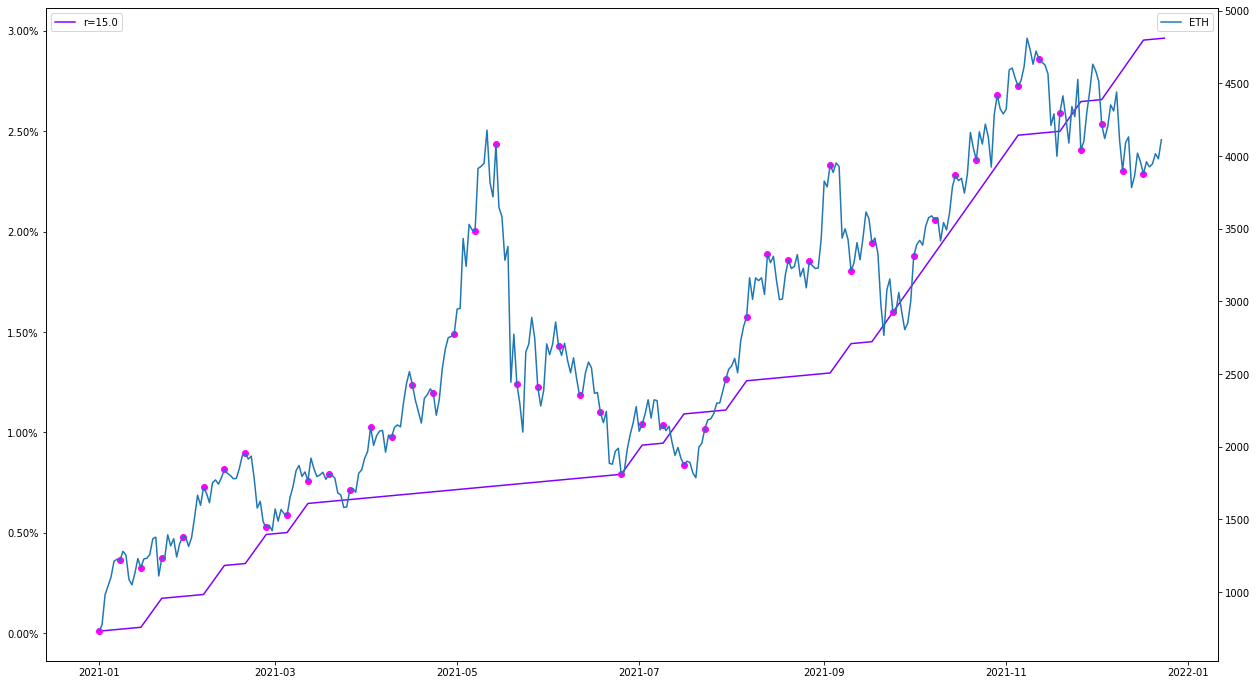

In [39]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
i = 52
data = data_eth
color = iter(cm.rainbow(np.linspace(0, 1, len(up_barriers))))
for up_barrier in up_barriers:
# for apy in apys:
    c = next(color)
    axs.plot(list(data.index)[::7][:i], 
            (1+highland[str(round(up_barrier*100,3))+'%'])[:i].cumprod(),
            color=c, label='r='+str(round(up_barrier*100,3)))
axs_=axs.twinx()
axs_.plot(list(data.index)[:7*(i-1)], 
        data['close'][:7*(i-1)],
        color='tab:blue', label='ETH')

axs_.scatter(list(data.index)[:7*(i-1):7], 
        data['close'][:7*(i-1):7],
        color='magenta')
xticks_axs_=axs.get_xticks()
# axs_.axhline(y=data['close'][:7*(i-1):7][1]*upper_pcg, 
# #              xmin=xticks_axs_[0], 
# #              xmax=xticks_axs_[2], 
#              linestyle='dashed')
# axs_.axhline(y=data['close'][:7*(i-1):7][1]*down_pcg, 
# #              xmin=list(data.index)[:7*(i-1):7][1], 
# #              xmax=list(data.index)[:7*(i-1):7][2], 
#              linestyle='dashed')
    
axs.legend(loc='upper left')
axs_.legend(loc='upper right')

# manipulate
# vals = axs.get_yticks()
# axs.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

### Corridor

In [126]:
data_months_eth = data_7days_eth_2021
eth_corridor_parameters= eth_7_corridor_parameters
index = ['month_'+str(i) for i in range(len(data_months_eth))]+['Avg', 'Max', 'CumProd']
index_parameters = list(eth_corridor_parameters.index) 
columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(eth_corridor_parameters['Lower Barrier'],
               eth_corridor_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(eth_corridor_parameters['Lower Barrier'],
               eth_corridor_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(eth_corridor_parameters['Lower Barrier'],
               eth_corridor_parameters['Upper Barrier'])]
corridor_eth = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(eth_corridor_parameters['Lower Barrier'],
                                              eth_corridor_parameters['Upper Barrier'],
                                              eth_corridor_parameters['Base Coupon'],
                                                  eth_corridor_parameters['Bonus Coupon']):
    for i in range(len(data_months_eth)):
        month = data_months_eth[i]
        S_0=month['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        month_performance_as_pcg = Corridor(month, upper_barrier, lower_barrier, bonus_coupon, 7)
        corridor_eth[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + month_performance_as_pcg) /52
        # APR, APY
        corridor_eth[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = corridor_eth[str([down_barrier, up_barrier])].iloc[i] * 52
        corridor_eth[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (corridor_eth[str([down_barrier, up_barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
corridor_eth.iloc[len(index)-3] = np.mean(corridor_eth)
corridor_eth.iloc[len(index)-2] = np.max(corridor_eth)
corridor_eth.iloc[len(index)-1] = (1+corridor_eth).cumprod().iloc[52]


/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [357]:
index = ['month_'+str(i) for i in range(len(data_months_btc))]+['Avg', 'Max', 'CumProd']
index_parameters = list(btc_corridor_parameters.index) 
columns = [str([down_barrier, up_barrier]) for down_barrier, up_barrier in 
           zip(btc_corridor_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_corridor_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier, up_barrier in 
           zip(btc_corridor_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_corridor_parameters['Upper Barrier'].loc[index_parameters[-1:]])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier, up_barrier in 
           zip(btc_corridor_parameters['Lower Barrier'].loc[index_parameters[-1:]],
               btc_corridor_parameters['Upper Barrier'].loc[index_parameters[-1:]])]
corridor_btc = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(btc_corridor_parameters['Lower Barrier'].loc[index_parameters[-1:]],
                                              btc_corridor_parameters['Upper Barrier'].loc[index_parameters[-1:]],
                                              btc_corridor_parameters['Base Coupon'].loc[index_parameters[-1:]],
                                                  btc_corridor_parameters['Bonus Coupon'].loc[index_parameters[-1:]]):
    for i in range(len(data_months_btc)):
        month = data_months_btc[i]
        S_0=month['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        month_performance_as_pcg = Corridor(month, upper_barrier, lower_barrier, bonus_coupon)
        corridor_btc[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + month_performance_as_pcg) /12
        # APR, APY
        corridor_btc[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = corridor_btc[str([down_barrier, up_barrier])].iloc[i] * 12
        corridor_btc[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (corridor_btc[str([down_barrier, up_barrier])].iloc[i] +1)** 12-1
# Avg, Max, CumProd
corridor_btc.iloc[len(index)-3] = np.mean(corridor_btc)
corridor_btc.iloc[len(index)-2] = np.max(corridor_btc)
corridor_btc.iloc[len(index)-1] = (1+corridor_btc).cumprod().iloc[12]


/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [128]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
data_weeks_eth = data_7days_eth_2021
eth_corridor_parameters= eth_7_corridor_parameters
index = ['week_'+str(i) for i in range(len(data_weeks_eth))]+['Avg', 'Max', 'CumProd']
columns = [str([down_barrier, up_barrier]) for down_barrier,up_barrier in 
           zip(eth_corridor_parameters['Lower Barrier'],
               eth_corridor_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier,up_barrier in 
           zip(eth_corridor_parameters['Lower Barrier'],
               eth_corridor_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier,up_barrier in 
           zip(eth_corridor_parameters['Lower Barrier'],
               eth_corridor_parameters['Upper Barrier'])]
corridor_eth = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(eth_corridor_parameters['Lower Barrier'],
                                              eth_corridor_parameters['Upper Barrier'],
                                              eth_corridor_parameters['Base Coupon'],
                                              eth_corridor_parameters['Bonus Coupon']):
    for i in range(len(data_weeks_eth)):
        week = data_weeks_eth[i]
        S_0=week['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        
        week_performance_as_pcg = Corridor(week, upper_barrier, lower_barrier, bonus_coupon, 7)
        corridor_eth[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + week_performance_as_pcg) /52
        # APR, APY
        corridor_eth[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = corridor_eth[str([down_barrier, up_barrier])].iloc[i] * 52
        corridor_eth[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (corridor_eth[str([down_barrier, up_barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
corridor_eth.iloc[len(index)-3] = np.mean(corridor_eth)
corridor_eth.iloc[len(index)-2] = np.max(corridor_eth)
corridor_eth.iloc[len(index)-1] = (1+corridor_eth).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [26]:
# strikes = [0.04]#[0.05, 0.08, 0.1]
# barriers = [0.09]#[0.08, 0.12, 0.15]
# base_coupons = [0.005]#[0.02, 0.015, 0.01]
# founding_rate = 0.025
index = ['week_'+str(i) for i in range(len(data_weeks_btc))]+['Avg', 'Max', 'CumProd']
columns = [str([down_barrier, up_barrier]) for down_barrier,up_barrier in 
           zip(btc_corridor_parameters['Lower Barrier'],
               btc_corridor_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APR' for down_barrier,up_barrier in 
           zip(btc_corridor_parameters['Lower Barrier'],
               btc_corridor_parameters['Upper Barrier'])]+[str([down_barrier, up_barrier])+'_APY' for down_barrier,up_barrier in 
           zip(btc_corridor_parameters['Lower Barrier'],
               btc_corridor_parameters['Upper Barrier'])]
corridor_btc = pd.DataFrame(index=index, 
                      columns = columns)
for down_barrier, up_barrier, base_coupon, bonus_coupon in zip(btc_corridor_parameters['Lower Barrier'],
                                              btc_corridor_parameters['Upper Barrier'],
                                              btc_corridor_parameters['Base Coupon'],
                                              btc_corridor_parameters['Bonus Coupon']):
    for i in range(len(data_weeks_btc)):
        week = data_weeks_btc[i]
        S_0=week['close'][0]
        lower_barrier=S_0*down_barrier
        upper_barrier=S_0*up_barrier
        
        week_performance_as_pcg = Corridor(week, upper_barrier, lower_barrier, bonus_coupon)
        corridor_btc[str([down_barrier, up_barrier])].iloc[i] = (base_coupon + week_performance_as_pcg) /52
        # APR, APY
        corridor_btc[str([down_barrier, up_barrier]) + '_APR'].iloc[i] = corridor_btc[str([down_barrier, up_barrier])].iloc[i] * 52
        corridor_btc[str([down_barrier, up_barrier]) + '_APY'].iloc[i] = (corridor_btc[str([down_barrier, up_barrier])].iloc[i] +1)** 52-1
# Avg, Max, CumProd
corridor_btc.iloc[len(index)-3] = np.mean(corridor_btc)
corridor_btc.iloc[len(index)-2] = np.max(corridor_btc)
corridor_btc.iloc[len(index)-1] = (1+corridor_btc).cumprod().iloc[52]

/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/agustin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [264]:
# (1+shark_fin_apy.dropna()).mean()
print("Average:\n",(corridor.dropna().mean()+1)**52-1)
print("\n")
print("Max:\n", (corridor.dropna().max()+1)**52-1)

Average:
 4.0%    0.04001
dtype: float64


Max:
 4.0%    0.072458
dtype: object


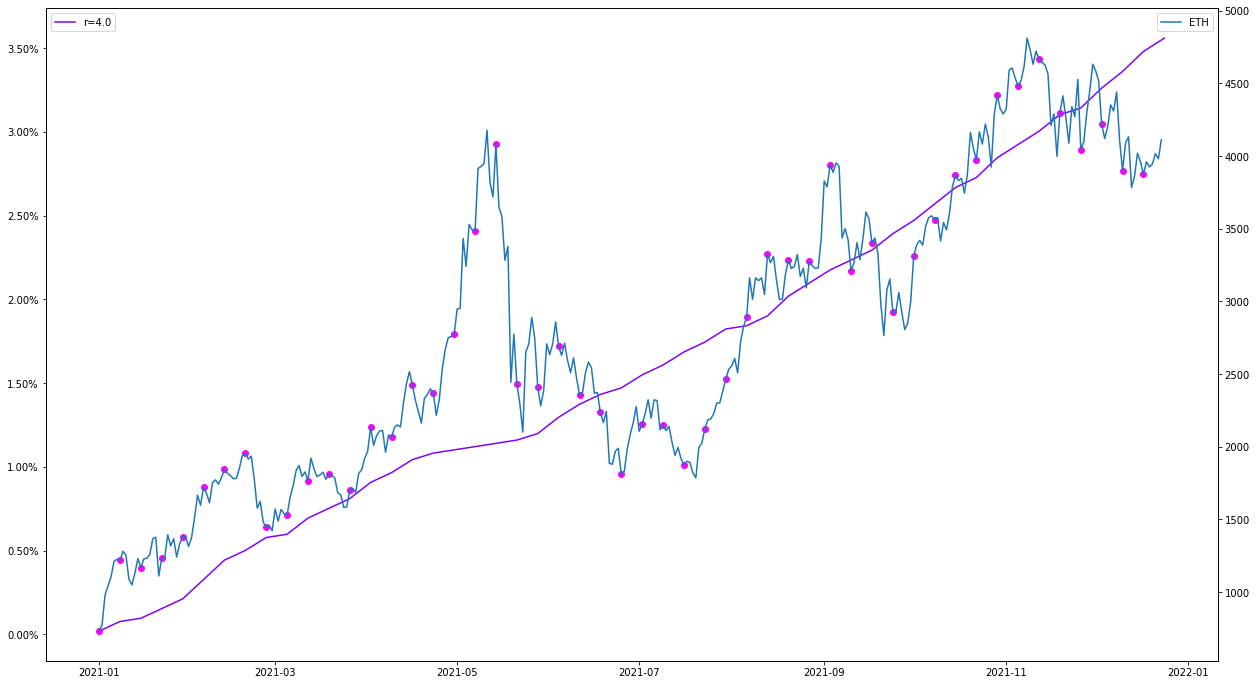

In [45]:
fig, axs = plt.subplots(1,1, figsize = (21,12))
i = 52
data = data_eth
color = iter(cm.rainbow(np.linspace(0, 1, len(up_barriers))))
for up_barrier in up_barriers:
# for apy in apys:
    c = next(color)
    axs.plot(list(data.index)[::7][:i], 
            (1+corridor[str(round(up_barrier*100,3))+'%'])[:i].cumprod(),
            color=c, label='r='+str(round(up_barrier*100,3)))
axs_=axs.twinx()
axs_.plot(list(data.index)[:7*(i-1)], 
        data['close'][:7*(i-1)],
        color='tab:blue', label='ETH')

axs_.scatter(list(data.index)[:7*(i-1):7], 
        data['close'][:7*(i-1):7],
        color='magenta')
xticks_axs_=axs.get_xticks()
# axs_.axhline(y=data['close'][:7*(i-1):7][1]*upper_pcg, 
# #              xmin=xticks_axs_[0], 
# #              xmax=xticks_axs_[2], 
#              linestyle='dashed')
# axs_.axhline(y=data['close'][:7*(i-1):7][1]*down_pcg, 
# #              xmin=list(data.index)[:7*(i-1):7][1], 
# #              xmax=list(data.index)[:7*(i-1):7][2], 
#              linestyle='dashed')
    
axs.legend(loc='upper left')
axs_.legend(loc='upper right')

# manipulate
# vals = axs.get_yticks()
# axs.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
axs.set_yticklabels([f'{x-1:.2%}' for x in axs.get_yticks()]) 
plt.show()

### COMPARISON

In [280]:
strategies = pd.DataFrame(
             columns = ['Ascent','Twin_peaks','Highland','Corridor'])
strategies['Ascent'] = ascent
strategies['Twin_peaks'] = twin_peaks
strategies['Highland'] = highland
strategies['Corridor'] = corridor

In [266]:
(1+strategies.dropna()).cumprod().tail()

,Ascent,Twin_peaks,Highland,Corridor
48,1.024032,1.029869,1.029346,1.036599
49,1.024131,1.031291,1.029445,1.037596
50,1.025623,1.031944,1.03093,1.038993
51,1.026127,1.032453,1.032416,1.040391
52,1.027122,1.032624,1.033906,1.040792


In [267]:
# (1+shark_fin_apy.dropna()).mean()
print("Average:\n", strategies.dropna().mean()*52)
print("\n")
print("Max:\n", strategies.dropna().max()*52)

Average:
 Ascent        0.026274
Twin_peaks    0.031516
Highland      0.032736
Corridor      0.039245
dtype: float64


Max:
 Ascent        0.130226
Twin_peaks    0.106636
Highland         0.075
Corridor          0.07
dtype: object


In [268]:
print("Simple interest cumlative: \n", 1+strategies.dropna().cumsum().tail().loc[52])
# print("Compound interest cumlative: \n", (1+strategies.dropna()).cumprod().tail().loc[52])
print("Average:\n",strategies.dropna().mean()*52)
print("\n")
# print("Max compound:\n", (strategies.dropna().max()+1)**52-1)
print("Max simple:\n", strategies.dropna().max()*52)

Simple interest cumlative: 
 Ascent        1.026779
Twin_peaks    1.032122
Highland      1.033365
Corridor          1.04
Name: 52, dtype: object
Average:
 Ascent        0.026274
Twin_peaks    0.031516
Highland      0.032736
Corridor      0.039245
dtype: float64


Max simple:
 Ascent        0.130226
Twin_peaks    0.106636
Highland         0.075
Corridor          0.07
dtype: object


In [281]:
pd.DataFrame(1+strategies.dropna().cumsum().tail().loc[52]).T.to_csv('hola_2021.csv')